# This solution is for the www.hackerearth.com competition Machine Learning Challenge #2

# Problem Statement
Kickstarter is a community of more than 10 million people comprising of creative, tech enthusiasts who help in bringing creative project to life. Till now, more than $3 billion dollars have been contributed by the members in fuelling creative projects. The projects can be literally anything – a device, a game, an app, a film etc.

Kickstarter works on all or nothing basis i.e if a project doesn’t meet it goal, the project owner gets nothing. For example: if a projects’s goal is 500. Even if it gets funded till 499, the project won’t be a success.

Recently, kickstarter released its public data repository to allow researchers and enthusiasts like us to help them solve a problem. Will a project get fully funded ?

In this challenge, we will have to predict if a project will get successfully funded or not?

In [371]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
from sklearn.preprocessing import LabelEncoder # encoding the categorical variables
from sklearn.preprocessing import binarize # for tranforming probability into classes

lbl = LabelEncoder() # function for encoding the variables

import matplotlib.pyplot as plt # for plotting
# for making the plots in the jupyter notebook
%matplotlib inline 
import seaborn as sns # for making plots with seaborn

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

We will read the train and test datasets using pandas

In [372]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

We will look at the shape of the train and test dataset

In [373]:
print ("Shape of train dataset is " + str(train.shape))
print ("Shape of rows in test dataset is " + str(test.shape))

Shape of train dataset is (108129, 14)
Shape of rows in test dataset is (63465, 12)


There are two less variables for test dataset. I was expecting the target variable to not be present in the test dataset but here there are two variables which are not present. Let us see which ones.

In [374]:
set(train.columns)-set(test.columns)

{'backers_count', 'final_status'}

The final_status and backers_count variables are not present in the test dataset. The final_status variable is the target variable whereas for the backers_count variable it has been mentioned in the forum section that it is released once the final_status has been decided for the project. So backers_count will be leaking information from the future if it is included from the model

In [375]:
print ('head of train')
train.head(2)

head of train


,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0


In [376]:
print ('head of test')
test.head(2)

head of test


,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at
0,kkst917493670,Bràthair.,"My first film, of many to come. Trying to purs...",7000.0,brathair,False,US,USD,1449619185,1449619185,1446002581,1446159585
1,kkst1664901914,THE SCREENWRITER,A young man that has earned his master's in sc...,35000.0,the-screenwriter,False,US,USD,1453435620,1453435620,1450297323,1450411620


As per my understanding, backers_count would have proved to be a very important variable but it is not present in the test dataset so we will have to drop it from the train dataset. Lets go ahead without this variable for the time being

We are going to store the project_id variable for prediction purposes later on

In [377]:
test_ids = test['project_id']

Lets see if any missing values are present in the datasets

In [378]:
pd.isnull(train).any().any()

True

In the train dataset, there are missing values. Lets see which features have missing values

In [379]:
pd.isnull(train).any()

project_id               False
name                      True
desc                      True
goal                     False
keywords                 False
disable_communication    False
country                  False
currency                 False
deadline                 False
state_changed_at         False
created_at               False
launched_at              False
backers_count            False
final_status             False
dtype: bool

Only the name and desc features have missing values

In [380]:
pd.isnull(test).any().any()

True

Likewise the test dataset also has missing values

In [381]:
pd.isnull(test).any()

project_id               False
name                     False
desc                      True
goal                     False
keywords                 False
disable_communication    False
country                  False
currency                 False
deadline                 False
state_changed_at         False
created_at               False
launched_at              False
dtype: bool

In test only the desc feature has missing values

Now we are going to convert the deadline, state_changed_at, created_at, launched_at variables from unix time format to time format

In [382]:
import time

In [383]:
cols =  ['deadline','state_changed_at','launched_at','created_at']
for col in cols:
    train[col] = train[col].apply(lambda k: time.ctime(k))
    test[col] = test[col].apply(lambda k: time.ctime(k))

In [384]:
train.head(2)

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,Sun May 3 12:29:59 2009,Sun May 3 12:30:17 2009,Sat Apr 25 00:45:07 2009,Sat Apr 25 01:22:03 2009,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,Sat May 16 04:40:00 2009,Sat May 16 05:30:18 2009,Wed Apr 29 04:40:24 2009,Wed Apr 29 08:56:32 2009,2,0


Lets do some feature engineering and feature creation

From the features name, desc and keywords we are going to create features which is going to denote the number of words and characters in those variables

In [385]:
train['len_name'] = train['name'].apply(str).apply(lambda x: len(x.split(' ')))
train['len_desc'] = train['desc'].apply(str).apply(lambda x: len(x.split(' ')))
train['len_keywords'] = train['keywords'].apply(str).apply(lambda x: len(x.split('-')))

test['len_name'] = test['name'].apply(str).apply(lambda x: len(x.split(' ')))
test['len_desc'] = test['desc'].apply(str).apply(lambda x: len(x.split(' ')))
test['len_keywords'] = test['keywords'].apply(str).apply(lambda x: len(x.split('-')))

In [386]:
train['count_name'] = train['name'].apply(str).apply(len)
train['count_desc'] = train['desc'].apply(str).apply(len)
train['count_keywords'] = train['keywords'].apply(str).apply(len)

test['count_name'] = test['name'].apply(str).apply(len)
test['count_desc'] = test['desc'].apply(str).apply(len)
test['count_keywords'] = test['keywords'].apply(str).apply(len)

Lets impute the missing values for len_name and len_desc variables in the train and test dataset. The missing values for these variables are those whose values are zero.

Lets see first of all how many missing values are there for len_name, len_desc in train dataset and for len_desc in test dataset

In [387]:
train['name'].isnull().values.ravel().sum()

1

In [388]:
train['desc'].isnull().values.ravel().sum()

8

In [389]:
test['desc'].isnull().values.ravel().sum()

4

The missing values are very less. We do not need to worry about them

In [390]:
train.head(2)

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status,len_name,len_desc,len_keywords,count_name,count_desc,count_keywords
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,Sun May 3 12:29:59 2009,Sun May 3 12:30:17 2009,Sat Apr 25 00:45:07 2009,Sat Apr 25 01:22:03 2009,3,1,3,26,3,19,134,19
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,Sat May 16 04:40:00 2009,Sat May 16 05:30:18 2009,Wed Apr 29 04:40:24 2009,Wed Apr 29 08:56:32 2009,2,0,10,25,10,76,137,74


Lets see how many values of disable_communication feature is there in the dataset

In [391]:
train['disable_communication'].value_counts()

False    107806
True        323
Name: disable_communication, dtype: int64

In [392]:
test['disable_communication'].value_counts()

False    63119
True       346
Name: disable_communication, dtype: int64

Lets see how many countries are there in the train and test dataset

In [393]:
train['country'].value_counts()

US    92033
GB     8758
CA     3736
AU     1880
NL      705
NZ      355
SE      240
DK      196
NO      114
IE      111
DE        1
Name: country, dtype: int64

In [394]:
test['country'].value_counts()

US    43129
GB     6900
CA     3275
AU     1846
DE     1633
FR     1255
IT     1127
ES      904
NL      686
SE      454
NZ      339
DK      300
CH      292
BE      274
IE      249
AT      223
NO      189
MX      172
SG      114
HK       82
LU       22
Name: country, dtype: int64

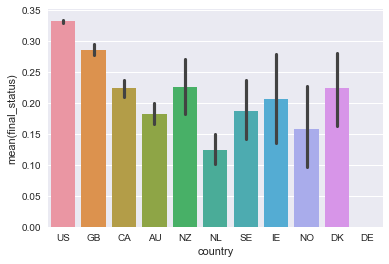

In [395]:
sns.barplot(x="country", y="final_status", data=train)

There are lots of values for country variable in the test dataset. We will have to reduce the number of values for country varaible in the test dataset. We are going to put the countries into 4 buckets. One bucket for US, one for GB, one for CA and the rest in a seperate bucket

In [396]:
train['country_category'] = np.zeros([train.shape[0],1])
train['country_category'].loc[train['country'] == 'US'] = 1
train['country_category'].loc[train['country'] == 'GB'] = 2
train['country_category'].loc[train['country'] == 'CA'] = 3

test['country_category'] = np.zeros([test.shape[0],1])
test['country_category'].loc[test['country'] == 'US'] = 1
test['country_category'].loc[test['country'] == 'GB'] = 2
test['country_category'].loc[test['country'] == 'CA'] = 3

In [397]:
train['currency'].value_counts()

USD    92033
GBP     8758
CAD     3736
AUD     1880
EUR      817
NZD      355
SEK      240
DKK      196
NOK      114
Name: currency, dtype: int64

In [398]:
test['currency'].value_counts()

USD    43129
GBP     6900
EUR     6373
CAD     3275
AUD     1846
SEK      454
NZD      339
DKK      300
CHF      292
NOK      189
MXN      172
SGD      114
HKD       82
Name: currency, dtype: int64

We are going to convert all the currences to USD. The conversion rates are {USD:1, GBP:1.27, CAD:0.76, AUD:0.76, EUR:1.12, NZD:0.72, SEK:0.11, DKK:0.15, NOK:0.12, CHF:1.03, MXN: 0.056, SGD: 0.72, HKD:0.13} as per Google


In [399]:
train['currency'] = train['currency'].map({'USD':1, 'GBP':1.27, 'CAD':0.76, 'AUD':0.76, 'EUR':1.12, 'NZD':0.72, 
                                           'SEK':0.11, 'DKK':0.15, 'NOK':0.12})
test['currency'] = test['currency'].map({'USD':1, 'GBP':1.27,'EUR':1.12, 'CAD':0.76, 'AUD':0.76, 
                                         'SEK':0.11, 'NZD':0.72, 'DKK':0.15, 'CHF':1.03, 'NOK':0.12,
                                        'MXN': 0.056, 'SGD': 0.72, 'HKD':0.13})

Lets convert the time variables to pandas date time like variables

In [400]:
cols =  ['deadline','state_changed_at','launched_at','created_at']
for col in cols:
    train[col] = pd.to_datetime(train[col])
    test[col] = pd.to_datetime(test[col])

In [401]:
train['deadline_year'] = train["deadline"].dt.year
train['deadline_month'] = train["deadline"].dt.month
train['deadline_day'] = train["deadline"].dt.day
train['deadline_hour'] = train["deadline"].dt.hour

train['state_changed_at_year'] = train["state_changed_at"].dt.year
train['state_changed_at_month'] = train["state_changed_at"].dt.month
train['state_changed_at_day'] = train["state_changed_at"].dt.day
train['state_changed_at_hour'] = train["state_changed_at"].dt.hour

train['created_at_year'] = train["created_at"].dt.year
train['created_at_month'] = train["created_at"].dt.month
train['created_at_day'] = train["created_at"].dt.day
train['created_at_hour'] = train["created_at"].dt.hour

train['launched_at_year'] = train["launched_at"].dt.year
train['launched_at_month'] = train["launched_at"].dt.month
train['launched_at_day'] = train["launched_at"].dt.day
train['launched_at_hour'] = train["launched_at"].dt.hour

test['deadline_year'] = test["deadline"].dt.year
test['deadline_month'] = test["deadline"].dt.month
test['deadline_day'] = test["deadline"].dt.day
test['deadline_hour'] = test["deadline"].dt.hour

test['state_changed_at_year'] = test["state_changed_at"].dt.year
test['state_changed_at_month'] = test["state_changed_at"].dt.month
test['state_changed_at_day'] = test["state_changed_at"].dt.day
test['state_changed_at_hour'] = test["state_changed_at"].dt.hour

test['created_at_year'] = test["created_at"].dt.year
test['created_at_month'] = test["created_at"].dt.month
test['created_at_day'] = test["created_at"].dt.day
test['created_at_hour'] = test["created_at"].dt.hour

test['launched_at_year'] = test["launched_at"].dt.year
test['launched_at_month'] = test["launched_at"].dt.month
test['launched_at_day'] = test["launched_at"].dt.day
test['launched_at_hour'] = test["launched_at"].dt.hour

Lets print the head of train again to get an idea

In [402]:
train.head(2)

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status,len_name,len_desc,len_keywords,count_name,count_desc,count_keywords,country_category,deadline_year,deadline_month,deadline_day,deadline_hour,state_changed_at_year,state_changed_at_month,state_changed_at_day,state_changed_at_hour,created_at_year,created_at_month,created_at_day,created_at_hour,launched_at_year,launched_at_month,launched_at_day,launched_at_hour
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,1.0,2009-05-03 12:29:59,2009-05-03 12:30:17,2009-04-25 00:45:07,2009-04-25 01:22:03,3,1,3,26,3,19,134,19,1.0,2009,5,3,12,2009,5,3,12,2009,4,25,0,2009,4,25,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,1.0,2009-05-16 04:40:00,2009-05-16 05:30:18,2009-04-29 04:40:24,2009-04-29 08:56:32,2,0,10,25,10,76,137,74,1.0,2009,5,16,4,2009,5,16,5,2009,4,29,4,2009,4,29,8


Now we are going to modify the goal variable. We are going to multiply the goal variable with currency to bring the amount to the same scale

In [403]:
train['goal'] = train['goal'] * train['currency']
test['goal'] = test['goal'] * test['currency']

disable_communication is a categorical variable and so we are encode it

In [404]:
l = lbl.fit(train['disable_communication'])
train['disable_communication'] = l.transform(train['disable_communication'])
test['disable_communication'] = l.transform(test['disable_communication'])

Lets print out the column names of the train dataset so that we can select the features to use for the target value prediction

In [405]:
np.ravel(train.columns.values)

array(['project_id', 'name', 'desc', 'goal', 'keywords',
       'disable_communication', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at', 'backers_count',
       'final_status', 'len_name', 'len_desc', 'len_keywords',
       'count_name', 'count_desc', 'count_keywords', 'country_category',
       'deadline_year', 'deadline_month', 'deadline_day', 'deadline_hour',
       'state_changed_at_year', 'state_changed_at_month',
       'state_changed_at_day', 'state_changed_at_hour', 'created_at_year',
       'created_at_month', 'created_at_day', 'created_at_hour',
       'launched_at_year', 'launched_at_month', 'launched_at_day',
       'launched_at_hour'], dtype=object)

In [406]:
features_to_use = ['goal','disable_communication','country_category',
                   'len_name','len_desc','len_keywords',
                   'count_name','count_desc', 'count_keywords', 
                   'deadline_year','deadline_month','deadline_day', 'deadline_hour',
                   'state_changed_at_year','state_changed_at_month','state_changed_at_day','state_changed_at_hour',
                   'created_at_year','created_at_month','created_at_day','created_at_hour',
                   'launched_at_year','launched_at_month','launched_at_day','launched_at_hour']

Lets print out the distribution of the target variable which is final_status in our case

In [407]:
train.final_status.value_counts()

0    73568
1    34561
Name: final_status, dtype: int64

In [408]:
train.final_status.value_counts()[1]/(train.final_status.value_counts()[1]+ train.final_status.value_counts()[0]) * 100

31.96274819891056

### Around 30% of projects were successfully completed
It is a binary classification problem and we need to remember this percentage of #1s in the train dataset. <b>It is very important</b>  
The value of 1 in the target variable will be refered to as #1 in the script

Lets do some baseline prediction using xgboost

In [409]:
import xgboost as xgb

#### Lets build a custom xgboost function

In [410]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=4000):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.01
    param['max_depth'] = 6
    param['silent'] = 0
    param['eval_metric'] = "error"
    param['min_child_weight'] = 5
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100,verbose_eval=100)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [411]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss

In [412]:
train_X = np.array(train[features_to_use])
train_y = np.array(train['final_status'])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.316035	test-error:0.325118
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.306463	test-error:0.316933
[200]	train-error:0.303261	test-error:0.31439
[300]	train-error:0.300845	test-error:0.312818
[400]	train-error:0.298047	test-error:0.311847
[500]	train-error:0.29592	test-error:0.31009
[600]	train-error:0.293909	test-error:0.309627
[700]	train-error:0.291701	test-error:0.308749
[800]	train-error:0.289655	test-error:0.307454
[900]	train-error:0.287054	test-error:0.305836
Stopping. Best iteration:
[878]	train-error:0.287585	test-error:0.305651

[0.69365578470359757]


A decent score to say the least

Lets do some hardcore visualization to improve the score

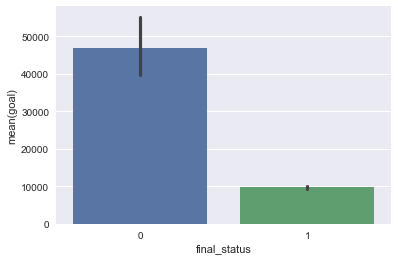

In [413]:
sns.barplot(x = 'final_status', y = 'goal', data = train)

As seen from the above barplot between goal and final_status, the projects whose goal amount is on the higher side has final_status as 0. Based on this we can create another variable goal_category to differentiate between low goal amount and high goal amount.  We are going to put the goal features in separate buckets

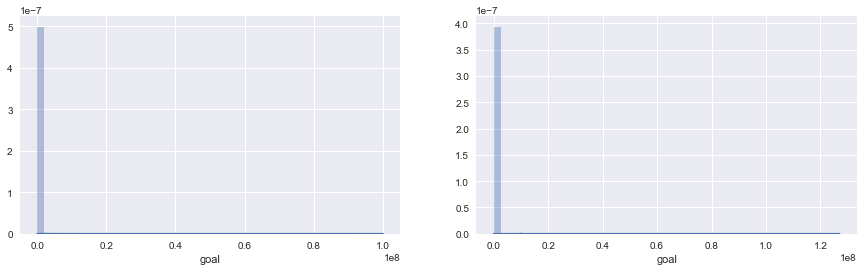

In [414]:
train['goal_category'] = np.zeros([train.shape[0],1])
train['goal_category'].loc[(train['goal'] >=10000) & (train['goal'] <20000)] = 1
train['goal_category'].loc[(train['goal'] >=20000) & (train['goal'] <30000)] = 2
train['goal_category'].loc[(train['goal'] >=30000) & (train['goal'] <40000)] = 3
train['goal_category'].loc[train['goal'] >=40000] = 4

test['goal_category'] = np.zeros([test.shape[0],1])
test['goal_category'].loc[(test['goal'] >=10000) & (test['goal'] <20000)] = 1
test['goal_category'].loc[(test['goal'] >=20000) & (test['goal'] <30000)] = 2
test['goal_category'].loc[(test['goal'] >=30000) & (test['goal'] <40000)] = 3
test['goal_category'].loc[test['goal'] >=40000] = 4

features_to_use.append('goal_category')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(train.goal, ax = axis1)
sns.distplot(test.goal, ax = axis2)

We will make the goal variable a normal distributed by applying logarithmic transformation on it

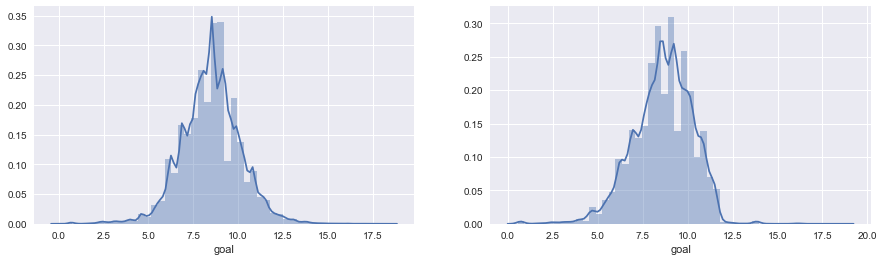

In [415]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(np.log1p(train.goal), ax = axis1)
sns.distplot(np.log1p(test.goal), ax = axis2)

The goal variable becomes normally distributed if we apply logarithmic transformation on it

In [416]:
train.goal = np.log1p(train.goal)
test.goal = np.log1p(test.goal)

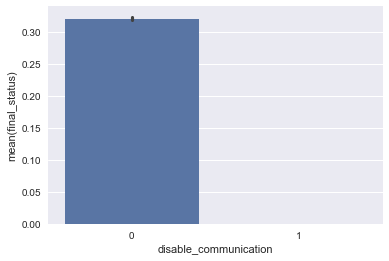

In [417]:
sns.barplot(x = 'disable_communication', y = 'final_status', data = train)

Lets leave the feature disable_communication for now

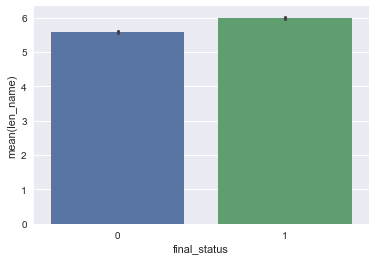

In [418]:
sns.barplot(x = 'final_status', y = 'len_name', data = train)

We can create another feature len_name_category based on the value of len_name greater than the mean when the final_status is 0

In [419]:
train['len_name_category'] = np.zeros([train.shape[0],1])
train['len_name_category'].loc[train['len_name'] > train.groupby(['final_status'])['len_name'].mean()[0]] = 1
test['len_name_category'] = np.zeros([test.shape[0],1])
test['len_name_category'].loc[test['len_name'] > train.groupby(['final_status'])['len_name'].mean()[0]] = 1

In [420]:
features_to_use.append('len_name_category')

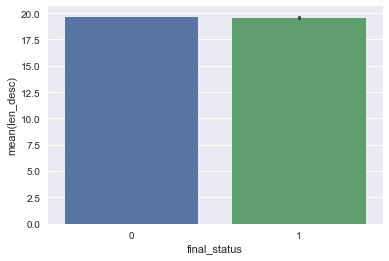

In [421]:
sns.barplot(x = 'final_status', y = 'len_desc', data = train)

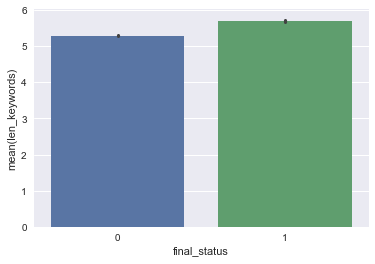

In [422]:
sns.barplot(x = 'final_status', y = 'len_keywords', data = train)

We can create another feature len_keywords_category based on the value of len_keywords greater than the mean when the final_status is 0

In [423]:
train['len_keywords_category'] = np.zeros([train.shape[0],1])
train['len_keywords_category'].loc[train['len_keywords'] >train.groupby(['final_status'])['len_keywords'].mean()[0]] = 1
test['len_keywords_category'] = np.zeros([test.shape[0],1])
test['len_keywords_category'].loc[test['len_keywords'] >train.groupby(['final_status'])['len_keywords'].mean()[0]] = 1

In [424]:
features_to_use.append('len_keywords_category')

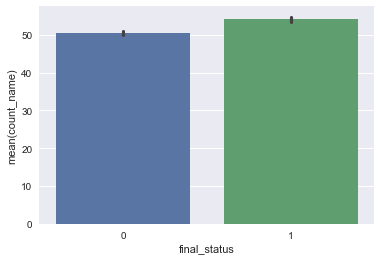

In [425]:
sns.barplot(x = 'final_status', y = 'count_name', data = train)

We are going to create a new variable count_name_category based on the value of count_name being greater than the mean the final_status is zero

In [426]:
train['count_name_category'] = np.zeros([train.shape[0],1])
train['count_name_category'].loc[train['count_name'] >train.groupby(['final_status'])['count_name'].mean()[0]] = 1
test['count_name_category'] = np.zeros([test.shape[0],1])
test['count_name_category'].loc[test['count_name'] >train.groupby(['final_status'])['count_name'].mean()[0]] = 1

In [427]:
features_to_use.append('count_name_category')

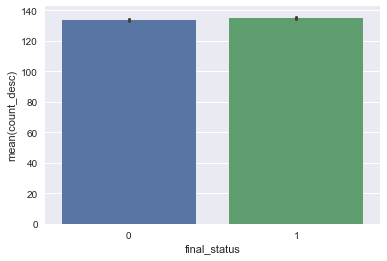

In [428]:
sns.barplot(x = 'final_status', y = 'count_desc', data = train)

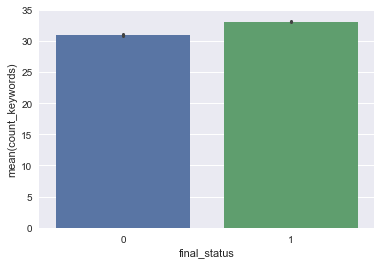

In [429]:
sns.barplot(x = 'final_status', y = 'count_keywords', data = train)

We are going to create a new variable count_keywords_category based on the value of count_keywords being greater than 30 or not

In [430]:
train['count_keywords_category'] = np.zeros([train.shape[0],1])
train['count_keywords_category'].loc[train['count_keywords'] >train.groupby(['final_status'])['count_keywords'].mean()[0]] = 1
test['count_keywords_category'] = np.zeros([test.shape[0],1])
test['count_keywords_category'].loc[test['count_keywords'] >train.groupby(['final_status'])['count_keywords'].mean()[0]] = 1

In [431]:
features_to_use.append('count_keywords_category')

Lets create a new variable created_at_deadline which will denote the time between deadline and created_at. I believe that the bigger this value will be the more the time the owners of the project will have for successful completion of the project

In [432]:
train['created_at_deadline'] = train['deadline'] - train['created_at']
train['created_at_deadline'] = train['created_at_deadline'].apply(lambda x: x.total_seconds()/3600) # to convert into hours
test['created_at_deadline'] = test['deadline'] - test['created_at']
test['created_at_deadline'] = test['created_at_deadline'].apply(lambda x: x.total_seconds()/3600) # to convert into hours

Let us look at the distribution of the created_at_deadline variable to see its distribution

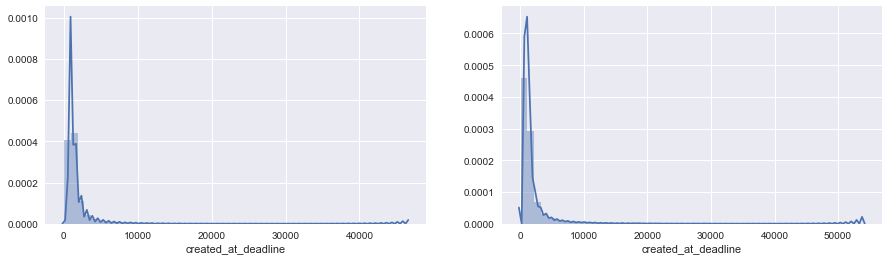

In [433]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(train.created_at_deadline, ax = axis1)
sns.distplot(test.created_at_deadline, ax = axis2)

Let us look at the distribution if we apply logarithmic transformation on it

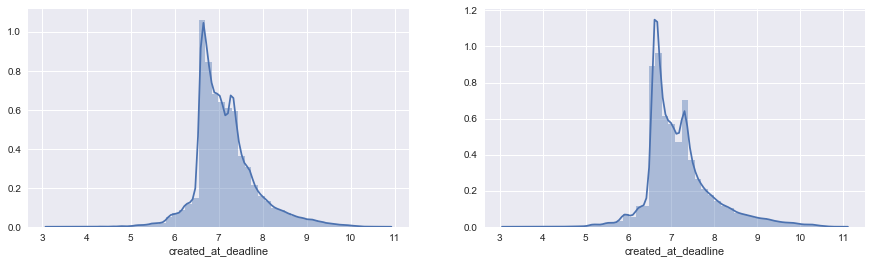

In [434]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(np.log1p(train.created_at_deadline), ax = axis1)
sns.distplot(np.log1p(test.created_at_deadline), ax = axis2)

Since it becomes close to normally distributed so we are going to apply logarithmic transformation on it

In [435]:
train.created_at_deadline = np.log1p(train.created_at_deadline)
test.created_at_deadline = np.log1p(test.created_at_deadline)

In [436]:
features_to_use.append('created_at_deadline')

Lets create another variable created_at_launched_at which will denote the time between created_at and launched_at.

In [437]:
train['created_at_launched_at'] = train['launched_at'] - train['created_at']
train['created_at_launched_at'] = train['created_at_launched_at'].apply(lambda x: x.total_seconds()/3600) # to convert into hours
test['created_at_launched_at'] = test['launched_at'] - test['created_at']
test['created_at_launched_at'] = test['created_at_launched_at'].apply(lambda x: x.total_seconds()/3600) # to convert into hours

In [438]:
features_to_use.append('created_at_launched_at')

Let us plot this variable and if it is not normally distributed then we will apply logarithmic transformation on it

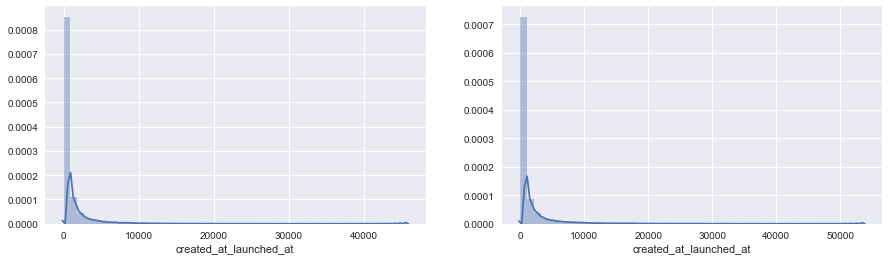

In [439]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(train['created_at_launched_at'], ax = axis1)
sns.distplot(test['created_at_launched_at'], ax = axis2)

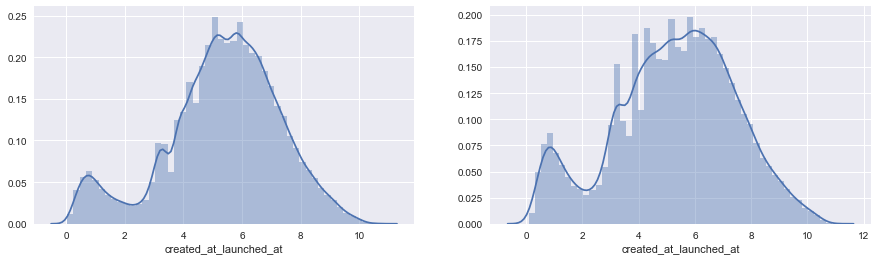

In [440]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(np.log1p(train['created_at_launched_at']), ax = axis1)
sns.distplot(np.log1p(test['created_at_launched_at']), ax = axis2)

After applying log-trasformation on the above variable, we see that its distribution becomes close to being normally distributed

In [441]:
train.created_at_launched_at = np.log1p(train.created_at_launched_at)
test.created_at_launched_at = np.log1p(test.created_at_launched_at)

Lets create another variable launched_at_deadline which will denote the time period between launched_at and deadline

In [442]:
train['launched_at_deadline'] = train['deadline'] - train['launched_at']
train['launched_at_deadline'] = train['launched_at_deadline'].apply(lambda x: x.total_seconds()/3600) # to convert into hours
test['launched_at_deadline'] = test['deadline'] - test['launched_at']
test['launched_at_deadline'] = test['launched_at_deadline'].apply(lambda x: x.total_seconds()/3600) # to convert into hours

In [443]:
features_to_use.append('launched_at_deadline')

Let us plot this variable and if it is not normally distributed then we will apply logarithmic transformation on it

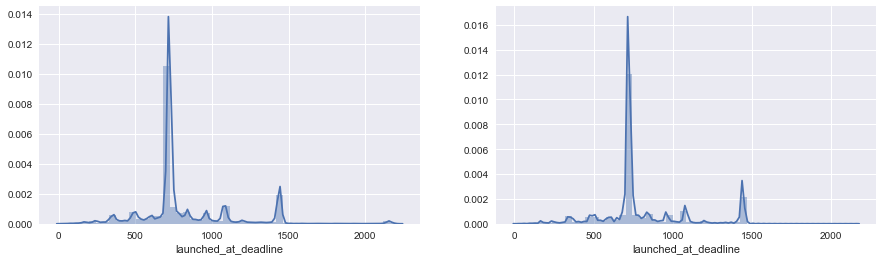

In [444]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(train.launched_at_deadline, ax = axis1)
sns.distplot(test.launched_at_deadline, ax = axis2)

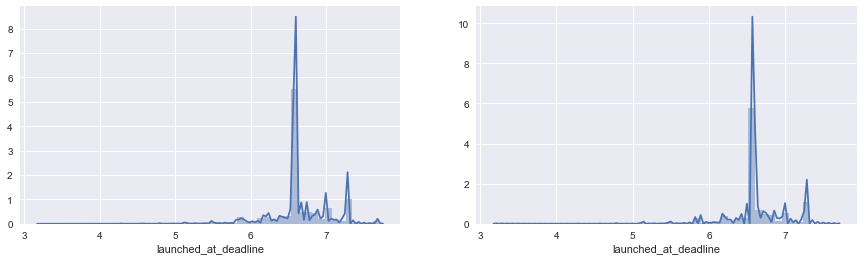

In [445]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(np.log1p(train.launched_at_deadline), ax = axis1)
sns.distplot(np.log1p(test.launched_at_deadline), ax = axis2)

We are going to apply log-transformation on the variable launched_at_deadline

In [446]:
train.launched_at_deadline = np.log1p(train.launched_at_deadline)
test.launched_at_deadline = np.log1p(test.launched_at_deadline)

Lets create another variable deadline_state_changed_at which will denote the time period between state_changed_at and deadline

In [447]:
train['deadline_state_changed_at'] = train['state_changed_at'] - train['deadline']
train['deadline_state_changed_at'] = train['deadline_state_changed_at'].apply(lambda x: x.total_seconds()/3600) # to convert into hours
test['deadline_state_changed_at'] = test['state_changed_at'] - test['deadline']
test['deadline_state_changed_at'] = test['deadline_state_changed_at'].apply(lambda x: x.total_seconds()/3600) # to convert into hours

In [448]:
features_to_use.append('deadline_state_changed_at')

Let us plot this variable and if it is not normally distributed then we will apply logarithmic transformation on it

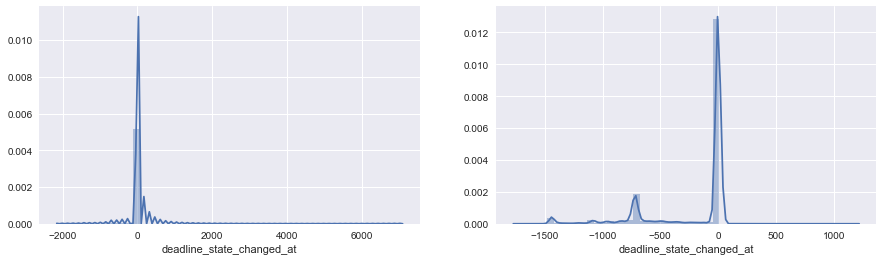

In [449]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(train.deadline_state_changed_at, ax = axis1)
sns.distplot(test.deadline_state_changed_at, ax = axis2)

Some values are negative for deadline_state_changed_at variable. So we are not apply log-transformation on it

Lets do some more plotting

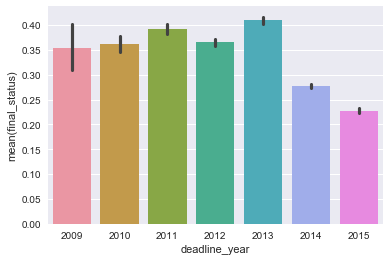

In [450]:
sns.barplot(x = 'deadline_year', y = 'final_status', data = train)

In [451]:
test['deadline_year'].value_counts()

2016    33124
2015    24722
2017     5619
Name: deadline_year, dtype: int64

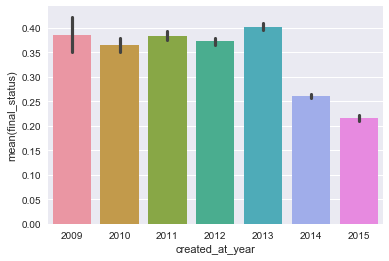

In [452]:
sns.barplot(x = 'created_at_year', y = 'final_status', data = train)

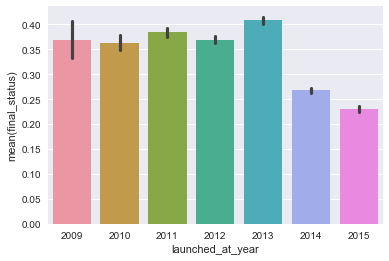

In [453]:
sns.barplot(x = 'launched_at_year', y = 'final_status', data = train)

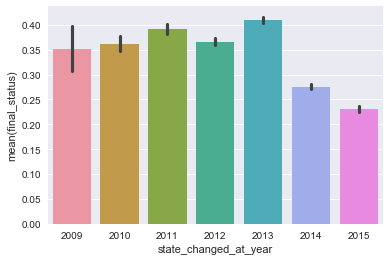

In [454]:
sns.barplot(x = 'state_changed_at_year', y = 'final_status', data = train)

The year variables characteristics are quite similar.

Lets plot the month variables for deadline, state_changed_at, launched_at, created_at and see if we can derive some interesting insights

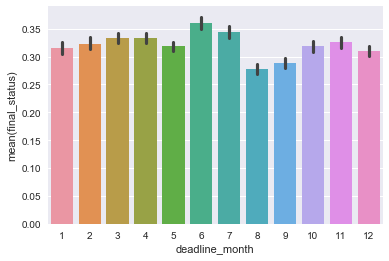

In [455]:
sns.barplot(x = 'deadline_month', y = 'final_status', data = train)

Lets put the deadline_month into buckets based on the above plot's mean(final_status) values

In [456]:
train['deadline_month_category'] = np.zeros([train.shape[0],1])
train['deadline_month_category'].loc[(train['deadline_month']<=5)|(train['deadline_month']>=10)] = 1
train['deadline_month_category'].loc[(train['deadline_month']>=6)|(train['deadline_month']<8)] = 2

test['deadline_month_category'] = np.zeros([test.shape[0],1])
test['deadline_month_category'].loc[(test['deadline_month']<=5)|(test['deadline_month']>=10)] = 1
test['deadline_month_category'].loc[(test['deadline_month']>=6)|(test['deadline_month']<8)] = 2

In [457]:
features_to_use.append('deadline_month_category')

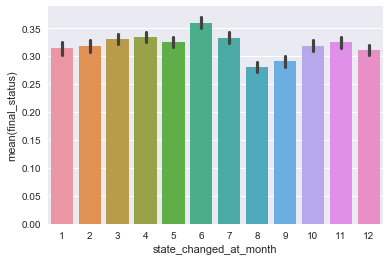

In [458]:
sns.barplot(x = 'state_changed_at_month', y = 'final_status', data = train)

Lets put the state_changed_at_month into buckets based on the above plot's mean(final_status) values

In [459]:
train['state_changed_at_month_category'] = np.zeros([train.shape[0],1])
train['state_changed_at_month_category'].loc[(train['state_changed_at_month']<=5)|(train['state_changed_at_month']>=10)|
                                            (train['state_changed_at_month']==7)] = 1
train['state_changed_at_month_category'].loc[(train['state_changed_at_month']>=8)|(train['state_changed_at_month']<10)] = 2

test['state_changed_at_month_category'] = np.zeros([test.shape[0],1])
test['state_changed_at_month_category'].loc[(test['state_changed_at_month']<=5)|(test['state_changed_at_month']>=10)|
                                           (test['state_changed_at_month']==7)] = 1
test['state_changed_at_month_category'].loc[(test['state_changed_at_month']>=8)|(test['state_changed_at_month']<10)] = 2

In [460]:
features_to_use.append('state_changed_at_month_category')

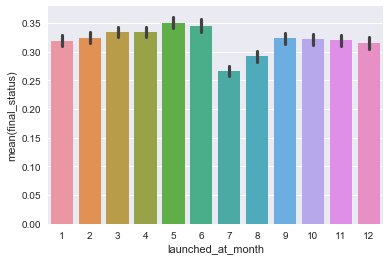

In [461]:
sns.barplot(x = 'launched_at_month', y = 'final_status', data = train)

Lets put the launched_at_month into buckets based on the above plot's mean(final_status) values

In [462]:
train['launched_at_month_category'] = np.zeros([train.shape[0],1])
train['launched_at_month_category'].loc[(train['launched_at_month']>6)|(train['launched_at_month']<8)] = 1
train['launched_at_month_category'].loc[(train['launched_at_month']>4)|(train['launched_at_month']<9)] = 2

test['launched_at_month_category'] = np.zeros([test.shape[0],1])
test['launched_at_month_category'].loc[(test['launched_at_month']>6)|(train['launched_at_month']<8)] = 1
test['launched_at_month_category'].loc[(test['launched_at_month']>4)|(test['launched_at_month']<9)] = 2

In [463]:
features_to_use.append('launched_at_month_category')

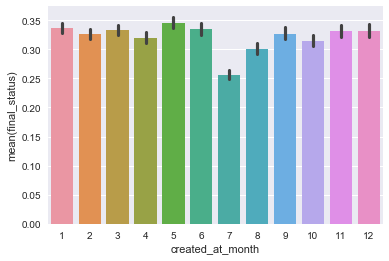

In [464]:
sns.barplot(x = 'created_at_month', y = 'final_status', data = train)

Lets put the created_at_month into buckets based on the above plot's mean(final_status) values

In [465]:
train['created_at_month_category'] = np.zeros([train.shape[0],1])
train['created_at_month_category'].loc[(train['created_at_month']==5)|(train['created_at_month']==6)] = 1
train['created_at_month_category'].loc[train['created_at_month']==7] = 2
train['created_at_month_category'].loc[train['created_at_month']==8] = 3

test['created_at_month_category'] = np.zeros([test.shape[0],1])
test['created_at_month_category'].loc[(test['created_at_month']==5)|(test['created_at_month']==6)] = 1
test['created_at_month_category'].loc[test['created_at_month']==7] = 2
test['created_at_month_category'].loc[test['created_at_month']==8] = 3

In [466]:
features_to_use.append('created_at_month_category')

Lets do some more exploration

In [467]:
train['deadline_state_changed_at'].max()

7098.7150000000001

The maximum time between state_changed_at and deadline is 7098 hours

In [468]:
train['deadline_state_changed_at'].min()

-2160.4800000000005

The minimum time between state_changed_at and deadline is negative signifying that the state of some projects were changed before the deadline. Based on this information, we can create another variable denoting whether deadline_state_changed_at is positive or negative

In [469]:
train['deadline_state_changed_at_sign'] = np.zeros([train.shape[0],1])
train['deadline_state_changed_at_sign'].loc[train['deadline_state_changed_at']>0] = 1

test['deadline_state_changed_at_sign'] = np.zeros([test.shape[0],1])
test['deadline_state_changed_at_sign'].loc[test['deadline_state_changed_at']>0] = 1

In [470]:
features_to_use.append('deadline_state_changed_at_sign')

Lets see what the distribution of the target variable is when the deadline_state_changed_at_sign is negative

In [471]:
deadline_state_changed_at_sign_0 = train['final_status'].loc[train['deadline_state_changed_at_sign']==0].value_counts()
deadline_state_changed_at_sign_0

0    36842
1    14989
Name: final_status, dtype: int64

In [472]:
deadline_state_changed_at_sign_0[1]/(deadline_state_changed_at_sign_0[0]+deadline_state_changed_at_sign_0[1]) *100

28.918986706797089

In [473]:
np.ravel(features_to_use)

array(['goal', 'disable_communication', 'country_category', 'len_name',
       'len_desc', 'len_keywords', 'count_name', 'count_desc',
       'count_keywords', 'deadline_year', 'deadline_month', 'deadline_day',
       'deadline_hour', 'state_changed_at_year', 'state_changed_at_month',
       'state_changed_at_day', 'state_changed_at_hour', 'created_at_year',
       'created_at_month', 'created_at_day', 'created_at_hour',
       'launched_at_year', 'launched_at_month', 'launched_at_day',
       'launched_at_hour', 'goal_category', 'len_name_category',
       'len_keywords_category', 'count_name_category',
       'count_keywords_category', 'created_at_deadline',
       'created_at_launched_at', 'launched_at_deadline',
       'deadline_state_changed_at', 'deadline_month_category',
       'state_changed_at_month_category', 'launched_at_month_category',
       'created_at_month_category', 'deadline_state_changed_at_sign'], 
      dtype='<U31')

#### Lets try logistic regression and see how it is performing

In [474]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [475]:
lr = LogisticRegression()
lr_score = cross_val_score(lr, train[features_to_use], train['final_status'], scoring = 'accuracy', cv = 5).mean()
lr_score

0.66256004684901326

Logistic regression is performing okayish

#### Lets try NaiveBayes and see how it is performing

In [476]:
from sklearn.naive_bayes import GaussianNB

In [477]:
gnb = GaussianNB()
gnb_score = cross_val_score(gnb, train[features_to_use], train['final_status'], scoring = 'accuracy', cv = 5).mean()
gnb_score

0.37971405162476829

Naive Bayes is not performing that well

#### Lets try out with a vanilla random forest

In [478]:
from sklearn.ensemble import RandomForestClassifier

In [479]:
rf = RandomForestClassifier(random_state=8)
rf_score = cross_val_score(rf, train[features_to_use], train['final_status'], scoring = 'accuracy', cv = 5).mean()
rf_score

0.39319784562892607

Similarly Random forest is also not performing that well

#### Lets run xgboost again

In [480]:
train_X = np.array(train[features_to_use])
train_y = np.array(train[['final_status']])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.314787	test-error:0.326829
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.299932	test-error:0.310645
[200]	train-error:0.295296	test-error:0.307639
[300]	train-error:0.290591	test-error:0.305419
[400]	train-error:0.287609	test-error:0.303708
[500]	train-error:0.284984	test-error:0.30209
[600]	train-error:0.283227	test-error:0.301165
[700]	train-error:0.281065	test-error:0.299408
[800]	train-error:0.279204	test-error:0.299408
[900]	train-error:0.276927	test-error:0.298345
[1000]	train-error:0.274164	test-error:0.297281
[1100]	train-error:0.27228	test-error:0.297142
[1200]	train-error:0.270083	test-error:0.296726
[1300]	train-error:0.268072	test-error:0.296125
[1400]	train-error:0.265956	test-error:0.295431
[1500]	train-error:0.263817	test-error:0.295709
Stopping. Best iteration:
[1410]	train-error:0.265679	test-error:0.2952

[0.70433737168223431]


In [481]:
len(features_to_use)

39

So the number of features that we are using for predicting the target variable is 39. Lets do some feature selection and see if we can improve the model. For feature selection, we are going to use chi2

In [482]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

For chi2 we have to pass non negative features for it to function. So, lets check which features have negative values

In [483]:
train[features_to_use].columns[(train[features_to_use] < 0).any()].tolist()

['deadline_state_changed_at']

Only one feature has negative value. Lets divide the features_to_use list into positive and negative features_to_use list. We are going to choose 33 features from our list of 38 positive features and then join it to the negative features

In [484]:
positive_features_to_use = features_to_use
positive_features_to_use.remove('deadline_state_changed_at')

In [485]:
negative_features_to_use =['deadline_state_changed_at']

In [486]:
selector = SelectKBest(chi2, k = 33)
selector.fit(train[positive_features_to_use], train[['final_status']])
idxs_selected = selector.get_support(indices=True)
new_positive_features = list(train[positive_features_to_use][idxs_selected].columns.values)

In [487]:
new_features = new_positive_features + negative_features_to_use

In [488]:
train_X = np.array(train[new_features])
train_y = np.array(train[['final_status']])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.314625	test-error:0.322621
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.300232	test-error:0.309905
[200]	train-error:0.295851	test-error:0.307084
[300]	train-error:0.290857	test-error:0.305096
[400]	train-error:0.287713	test-error:0.303847
[500]	train-error:0.284753	test-error:0.302183
[600]	train-error:0.28295	test-error:0.30098
[700]	train-error:0.281042	test-error:0.299131
[800]	train-error:0.279227	test-error:0.298576
[900]	train-error:0.276823	test-error:0.297882
[1000]	train-error:0.274823	test-error:0.296819
Stopping. Best iteration:
[992]	train-error:0.275193	test-error:0.296356

[0.70336631832054008]


Choosing important features through chi2 didnot improve our performance but the difference between train error and test error has decreased dramatically. A higher difference between train and test error means that we are overfitting. Lets find out which columns are being responsible for overfitting

In [489]:
set(features_to_use) - set(new_features)

{'deadline_month_category',
 'launched_at_month_category',
 'launched_at_year',
 'state_changed_at_month_category',
 'state_changed_at_year'}

Lets do feature selection using Random forest and we are going to choose 34 most important features

In [490]:
rf.fit(train[features_to_use], train['final_status'])
importances = pd.DataFrame({'feature':train[features_to_use].columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values(by = 'importance', ascending=False)
importances

,feature,importance
31,created_at_launched_at,0.071
0,goal,0.070
30,created_at_deadline,0.063
32,launched_at_deadline,0.051
7,count_desc,0.050
6,count_name,0.047
19,created_at_day,0.045
20,created_at_hour,0.043
23,launched_at_day,0.043
4,len_desc,0.042


In [491]:
new_features = []
count = 0
for row in range(importances.shape[0]):
    new_features.append(importances.iloc[row,0])
    count += 1
    if count >33:
        break

In [492]:
len(new_features)

34

In [493]:
train_X = np.array(train[new_features])
train_y = np.array(train['final_status'])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.314035	test-error:0.328031
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.301492	test-error:0.313465
[200]	train-error:0.296961	test-error:0.309442
[300]	train-error:0.292591	test-error:0.307408
[400]	train-error:0.288684	test-error:0.30357
[500]	train-error:0.285585	test-error:0.301859
[600]	train-error:0.283401	test-error:0.30098
[700]	train-error:0.280823	test-error:0.300148
[800]	train-error:0.278672	test-error:0.299917
[900]	train-error:0.276753	test-error:0.29853
[1000]	train-error:0.273956	test-error:0.29779
[1100]	train-error:0.272176	test-error:0.297697
Stopping. Best iteration:
[1037]	train-error:0.273517	test-error:0.29705

[0.70253398686765933]


Feature selection using random forest and chi2 is not proving to be useful

Let us check again what all features we were using

In [494]:
np.ravel(features_to_use)

array(['goal', 'disable_communication', 'country_category', 'len_name',
       'len_desc', 'len_keywords', 'count_name', 'count_desc',
       'count_keywords', 'deadline_year', 'deadline_month', 'deadline_day',
       'deadline_hour', 'state_changed_at_year', 'state_changed_at_month',
       'state_changed_at_day', 'state_changed_at_hour', 'created_at_year',
       'created_at_month', 'created_at_day', 'created_at_hour',
       'launched_at_year', 'launched_at_month', 'launched_at_day',
       'launched_at_hour', 'goal_category', 'len_name_category',
       'len_keywords_category', 'count_name_category',
       'count_keywords_category', 'created_at_deadline',
       'created_at_launched_at', 'launched_at_deadline',
       'deadline_month_category', 'state_changed_at_month_category',
       'launched_at_month_category', 'created_at_month_category',
       'deadline_state_changed_at_sign'], 
      dtype='<U31')

##### Text Features - The text mining idea has been taken from hackerearth's tutorial itself

We are going to apply text mining to keywords and desc features

In [495]:
from nltk.corpus import stopwords # for importing stopwords
import re # for importing regular expression
from nltk.stem.snowball import SnowballStemmer # for importing the stemmer which will bring the words to their base forms
# for importing the vectorizer which will transform the words into numerical values
from sklearn.feature_extraction.text import TfidfVectorizer 

In [496]:
desc_series = pd.Series(train['desc'].tolist() + test['desc'].tolist()).astype(str) # join the desc series of train and test
keywords_series = pd.Series(train['keywords'].tolist() + test['keywords'].tolist()).astype(str) # join the keywords series

In [497]:
# this function cleans punctuations, digits and irregular tabs. Then converts the sentences to lower
def clean(word):
    p1 = re.sub(pattern='(\W+)|(\d+)|(\s+)',repl=' ',string=word)
    p1 = p1.lower()
    return p1

desc_series = desc_series.map(clean)
keywords_series = keywords_series.map(clean)

In [498]:
stop = set(stopwords.words('english')) # english stopwords
stemmer = SnowballStemmer(language='english') # stemmer function

In [499]:
# removing stopwords
desc_series = [[x for x in x.split() if x not in stop] for x in desc_series]
keywords_series = [[x for x in x.split() if x not in stop] for x in keywords_series]

# stemming the words
desc_series = [[stemmer.stem(x) for x in x] for x in desc_series]
keywords_series = [[stemmer.stem(x) for x in x] for x in keywords_series]

# joining the words back together
desc_series = [' '.join(x) for x in desc_series]
keywords_series = [' '.join(x) for x in keywords_series]

#### Creating tfidf features  
The maximum number of features for tfidf vectorizer would be taken as 150

In [500]:
tfidf = TfidfVectorizer(max_features=150)

In [502]:
alldesc = tfidf.fit_transform(desc_series).todense()
allkey = tfidf.fit_transform(keywords_series).todense()

In [503]:
desc_combine = pd.DataFrame(alldesc)
desc_combine.rename(columns= lambda x: 'variable_desc_'+ str(x), inplace=True)

key_combine = pd.DataFrame(allkey)
key_combine.rename(columns= lambda x: 'variable_key_'+ str(x), inplace=True)

# the text mining variables were named differently so as to identify them from the earlier variables that we had created

In [504]:
train_desc = desc_combine[:train.shape[0]]
test_desc = desc_combine[train.shape[0]:]

train_key = key_combine[:train.shape[0]]
test_key = key_combine[train.shape[0]:]

In [505]:
train_text = pd.concat([train, train_desc, train_key], axis = 1)

In [506]:
# indexes were reset so that no problem occurs during the concatenation by pandas and the concatenation happens properly
test.reset_index(drop=True, inplace=True)
test_desc.reset_index(drop=True, inplace=True)
test_key.reset_index(drop=True, inplace=True)
test_text = pd.concat([test, test_desc, test_key], axis = 1)

In [507]:
# include the variables related to description features to the list features_to_use
for col in desc_combine.columns.values:
    features_to_use.append(col)

# include the variables related to keywords features to the list features_to_use
for col in key_combine.columns.values:
    features_to_use.append(col)

In [508]:
train_text.shape

(108129, 351)

#### Lets run a logistic regression model again on earlier features along with text features

In [509]:
lr = LogisticRegression()
lr_score = cross_val_score(lr, train_text[features_to_use], train_text['final_status'], scoring = 'accuracy', cv = 5).mean()
lr_score

0.67560023087462384

The score for logistic regression has improved

In [510]:
# Let us make a submission with logistic regression and see the leaderboard score
lr.fit(train_text[features_to_use], np.ravel(train_text['final_status']))
test_X = test_text[features_to_use]
preds_lr_new = lr.predict(test_X)
percentage_lr_new = (np.bincount(preds_lr_new)[1]/(np.bincount(preds_lr_new)[0]
                                                   +np.bincount(preds_lr_new)[1])) * 100
print ("#1s percentage in the prediction is " + str(percentage_lr_new))

#1s percentage in the prediction is 7.57425352557


In [511]:
submission = pd.DataFrame({"final_status":preds_lr_new})
submission.insert(0, "project_id", test_ids)
submission.to_csv("lr_0.5th_150tf.csv", index=False) #0.68414 leaderboard score

#### Lets run an xgboost model again on earlier features along with text features
We will name this model as 'model'

In [512]:
train_X = np.array(train_text[features_to_use])
train_y = np.array(train_text['final_status'])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.312082	test-error:0.32595
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.297654	test-error:0.309951
[200]	train-error:0.292533	test-error:0.306575
[300]	train-error:0.28762	test-error:0.30357
[400]	train-error:0.283158	test-error:0.300518
[500]	train-error:0.278892	test-error:0.29853
[600]	train-error:0.275898	test-error:0.296819
[700]	train-error:0.272892	test-error:0.29557
[800]	train-error:0.269655	test-error:0.295246
[900]	train-error:0.267528	test-error:0.29409
[1000]	train-error:0.265078	test-error:0.293674
[1100]	train-error:0.263078	test-error:0.292703
[1200]	train-error:0.261055	test-error:0.292333
[1300]	train-error:0.259101	test-error:0.2909
[1400]	train-error:0.257413	test-error:0.290807
[1500]	train-error:0.255193	test-error:0.290114
[1600]	train-error:0.253228	test-error:0.28905
[1700]	train-error:0.251598	test-error:0.288033
[1800]	trai

#### Lets make a prediction using the xgboost model named 'model' and see how it is performing

In [513]:
test_X = np.array(test_text[features_to_use])
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)
preds_binarize = binarize([preds], 0.5)[0].astype(int)
submission = pd.DataFrame({"final_status":preds_binarize})
submission.insert(0, "project_id", test_ids)
submission.to_csv("xgb_starter_0.5th_150tf.csv", index=False) #0.69693. 
# It is a dissapointing score Lets see why that is happening

In [514]:
# Lets check the head of submission and see if it is matching with the submission format
submission.head()

,project_id,final_status
0,kkst917493670,0
1,kkst1664901914,0
2,kkst925125077,0
3,kkst1427645275,0
4,kkst1714249266,0


The format of the submission file is matching the requirement
#### Lets check how many #1s and #0s are there in the submission file

In [515]:
submission['final_status'].value_counts()

0    59877
1     3588
Name: final_status, dtype: int64

In [516]:
# Print the #1s percentage in the submission file
percentage = (submission['final_status'].value_counts()[1]/(submission['final_status'].value_counts()[0]
                                                           +submission['final_status'].value_counts()[1])) * 100
print ("#1s percentage in the submission file is " + str(percentage))

#1s percentage in the submission file is 5.65350980856


#### We know that the percentage of #1s in the train dataset is around 30%. So our model is not being able to capture the relationships of the data when the final status is 1. Imbalanced classifiaction problem anyone but the dataset is not that imbalanced

In [517]:
# Lets check the #1s if we use the logistic regression model named as lr
lr.fit(train_text[features_to_use], np.ravel(train_text['final_status']))
test_X = test_text[features_to_use]
preds_lr = lr.predict(test_X)

In [518]:
percentage_lr = (np.bincount(preds_lr)[1]/(np.bincount(preds_lr)[0]
                                        +np.bincount(preds_lr)[1])) * 100
print ("#1s percentage in the submission file is " + str(percentage_lr))

#1s percentage in the submission file is 7.57425352557


Logistic regression is also giving a very low value of #1s

In [519]:
# plot the mean values of final_status according to the year in the final dataset
deadline_year_final_status = round(train_text.groupby(['deadline_year'])['final_status'].mean() * 100, 2)

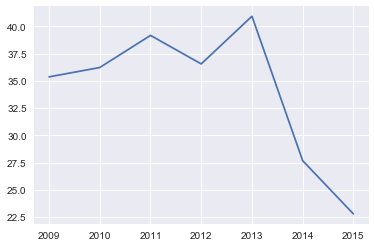

In [520]:
plt.plot(deadline_year_final_status)

In [521]:
# Lets see the distribution of deadline year in the train dataset
train_text['deadline_year'].value_counts()

2014    35979
2015    20681
2013    18923
2012    18382
2011    10102
2010     3652
2009      410
Name: deadline_year, dtype: int64

In [522]:
# Lets see the distribution of deadline year in the test dataset
test_text['deadline_year'].value_counts()

2016    33124
2015    24722
2017     5619
Name: deadline_year, dtype: int64

#### Experiment 1
##### We are going to train on 2013, 2014, 2015 deadline year data and predict on the test dataset. Lets see what kind of distribution , this particular type of experiment generates

In [523]:
# Lets check how many samples are there in the train dataset for deadline_year 2014 and 2015 deadline_year
((train_text['deadline_year']==2013)|
 (train_text['deadline_year']==2014)|
 (train_text['deadline_year']==2015)).value_counts()

True     75583
False    32546
Name: deadline_year, dtype: int64

In [524]:
# For this particular experiment, the train dataset is going to consist of 56660 samples
train_text_recent = pd.concat([train_text[train_text['deadline_year']==2013], 
                                  train_text[train_text['deadline_year']==2014],
                                  train_text[train_text['deadline_year']==2015]],
                                 axis = 0)
train_text_recent.shape

(75583, 351)

In [525]:
# Lets try out logistic regression again and check out its local cv score
lr1 = LogisticRegression()
lr1_score = cross_val_score(lr1, train_text_recent[features_to_use], np.ravel(train_text_recent['final_status']), scoring = 'accuracy', cv = 5).mean()
lr1_score

0.6832102346213812

In [526]:
# Lets check the #1s after predicting with logistic regression on the new train
lr1.fit(train_text_recent[features_to_use], np.ravel(train_text_recent['final_status']))
test_X = test_text[features_to_use]
preds_lr1_new = lr1.predict(test_X)
percentage_lr_new = (np.bincount(preds_lr1_new)[1]/(np.bincount(preds_lr1_new)[0]
                                                    +np.bincount(preds_lr1_new)[1])) * 100
print ("#1s percentage in the prediction is " + str(percentage_lr_new))

#1s percentage in the prediction is 10.5617269361


The #1s percentage in the prediction is still around 10%

In [527]:
# lets make a submission using the above model and see the leaderboard score
submission = pd.DataFrame({"final_status":preds_lr1_new})
submission.insert(0, "project_id", test_ids)
submission.to_csv("lr1_0.5th_150tf.csv", index=False) #0.69677 leaderboard score

In [528]:
# join the prediction of test predictions with test dataset
test_text_copy = test_text.copy()
test_text_copy['final_status'] = preds_lr_new

In [529]:
#Lets check the distribution of #1s after grouping by deadline year
# we will see the percentage of #1s in target variable for different years in the test dataset
round(test_text_copy.groupby(['deadline_year'])['final_status'].mean() * 100, 2)

deadline_year
2015    7.81
2016    7.17
2017    8.92
Name: final_status, dtype: float64

In [530]:
# lets see the percentage of #1s in the target feature of train dataset
(train_text_recent['final_status'].value_counts()[1]/(train_text_recent['final_status'].value_counts()[1] + 
                                                    train_text_recent['final_status'].value_counts()[0]))*100

29.654816559279201

#### It is quite strange that the #1s percentage in test dataset is plummeting downward

Lets compare the distribution of features other than text features in the train and test dataset when final status is 1 in the train dataset

Distribution of goal


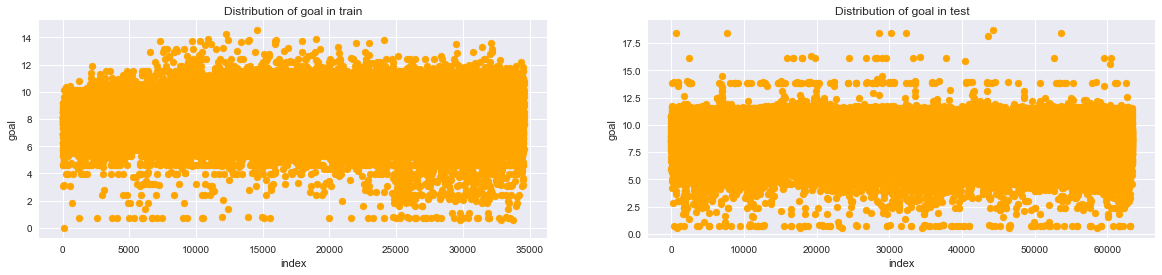

Distribution of disable_communication


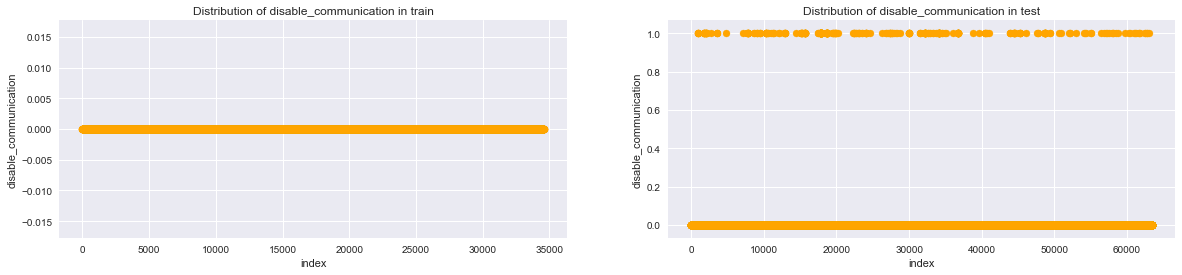

Distribution of country_category


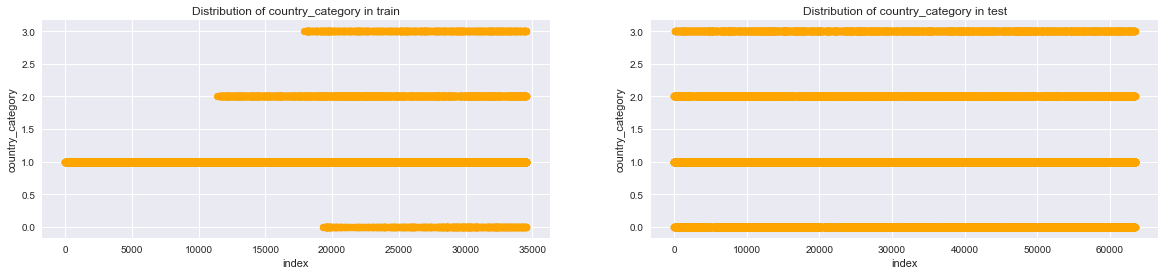

Distribution of len_name


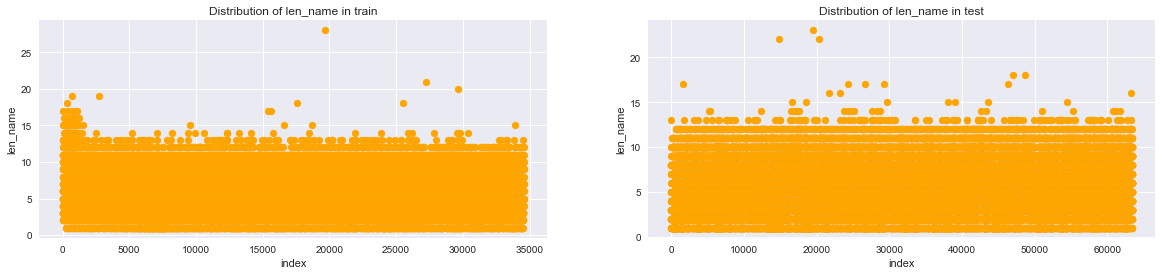

Distribution of len_desc


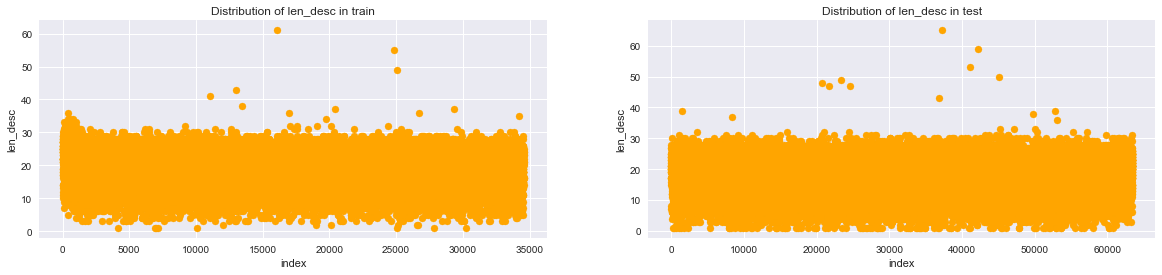

Distribution of len_keywords


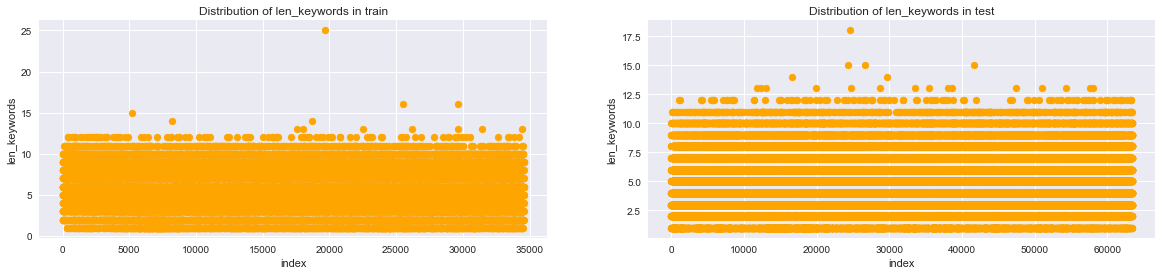

Distribution of count_name


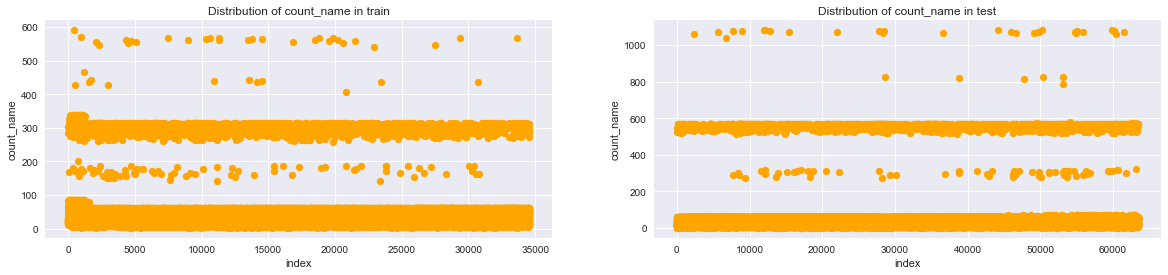

Distribution of count_desc


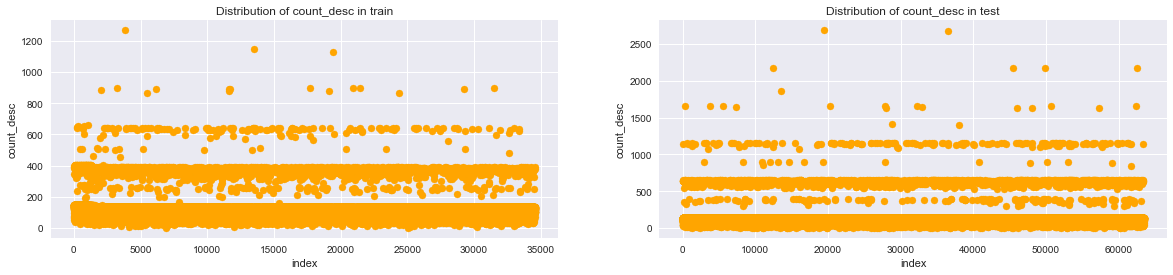

Distribution of count_keywords


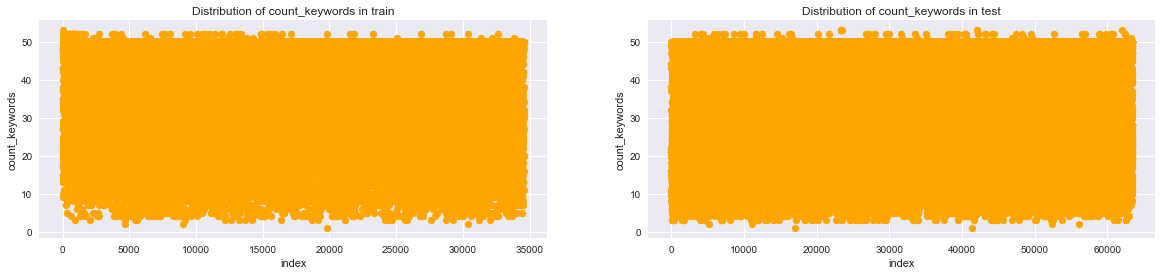

Distribution of deadline_year


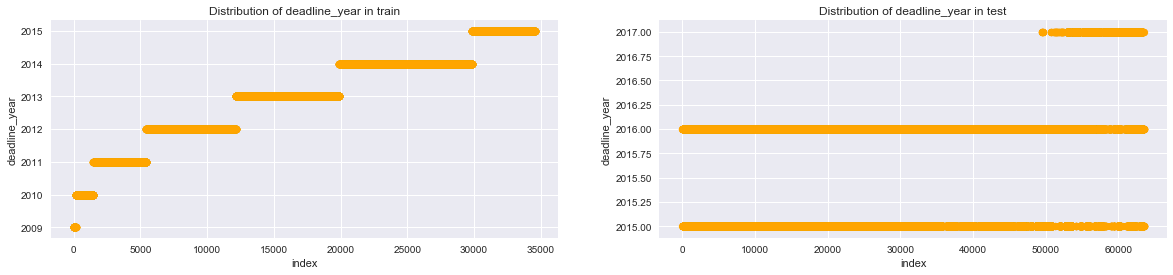

Distribution of deadline_month


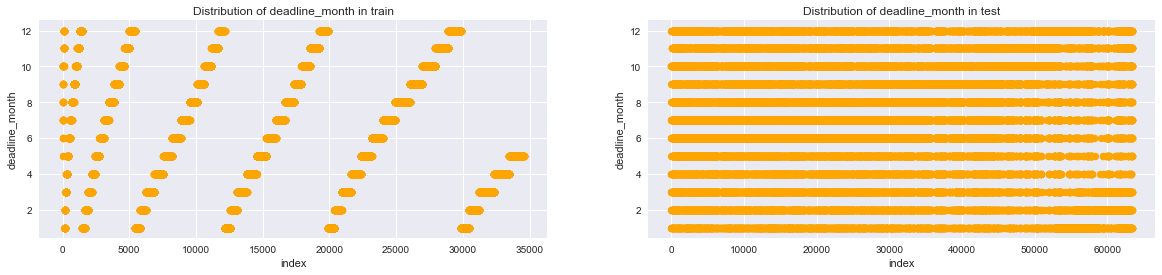

Distribution of deadline_day


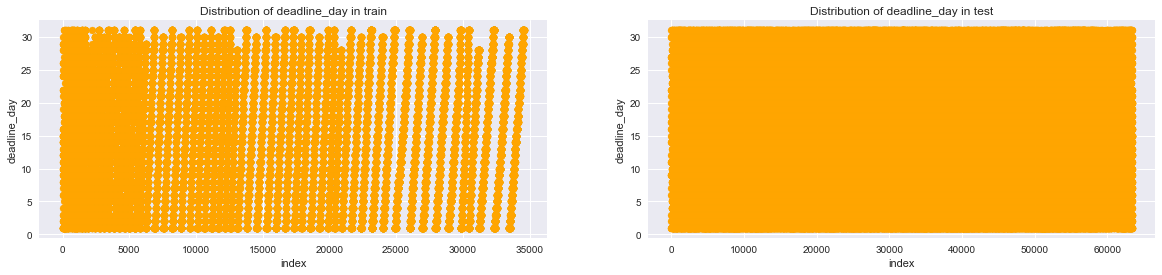

Distribution of deadline_hour


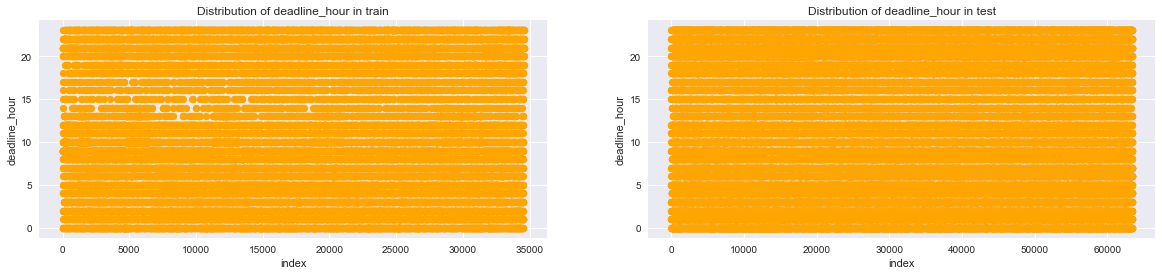

Distribution of state_changed_at_year


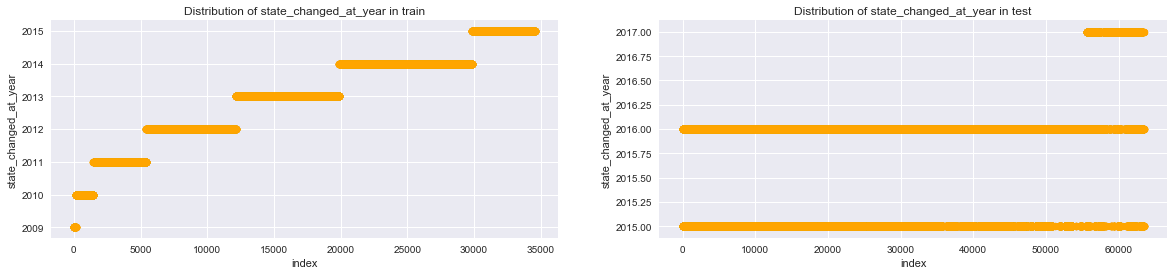

Distribution of state_changed_at_month


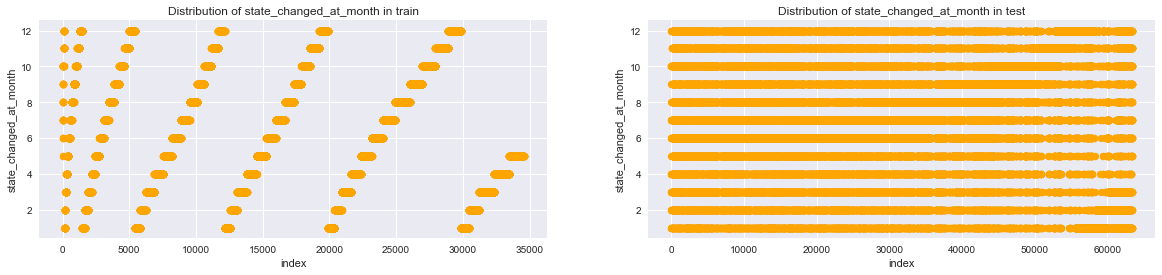

Distribution of state_changed_at_day


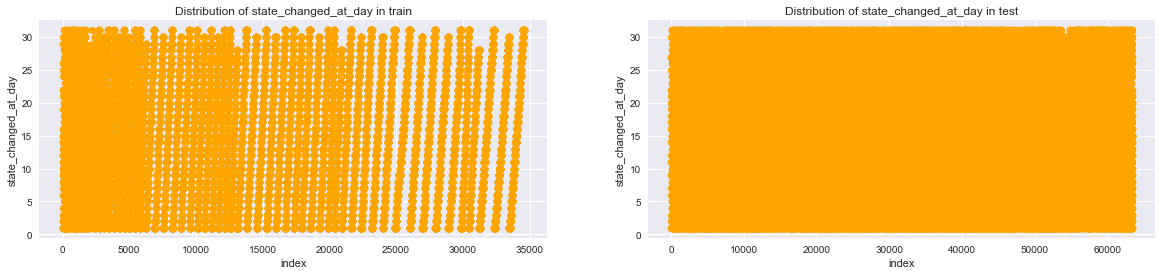

Distribution of state_changed_at_hour


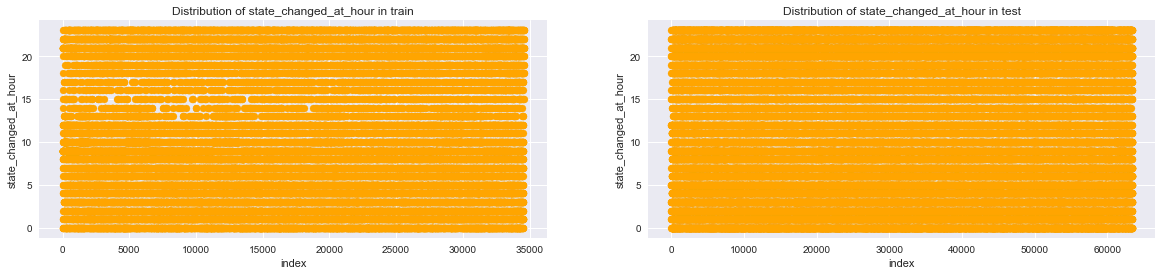

Distribution of created_at_year


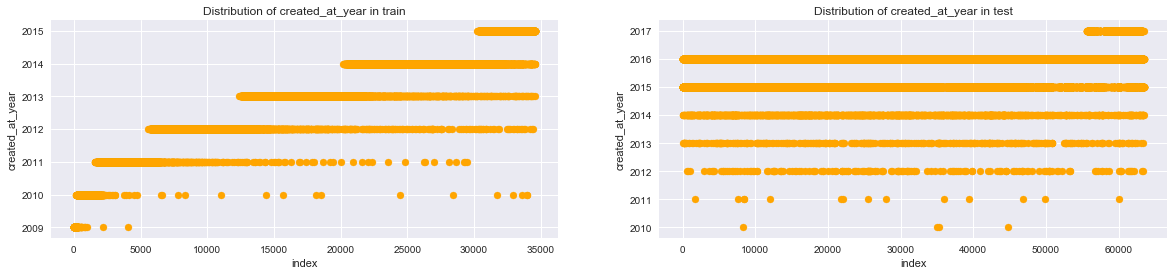

Distribution of created_at_month


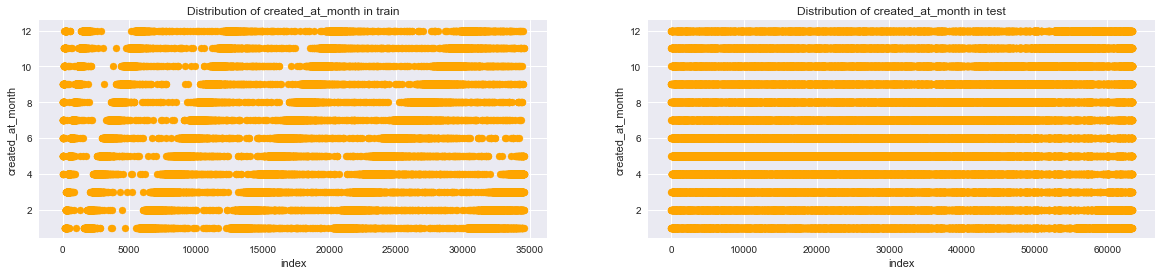

Distribution of created_at_day


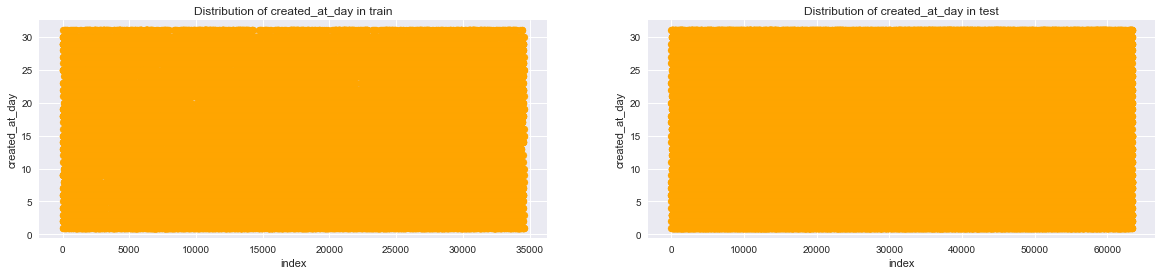

Distribution of created_at_hour


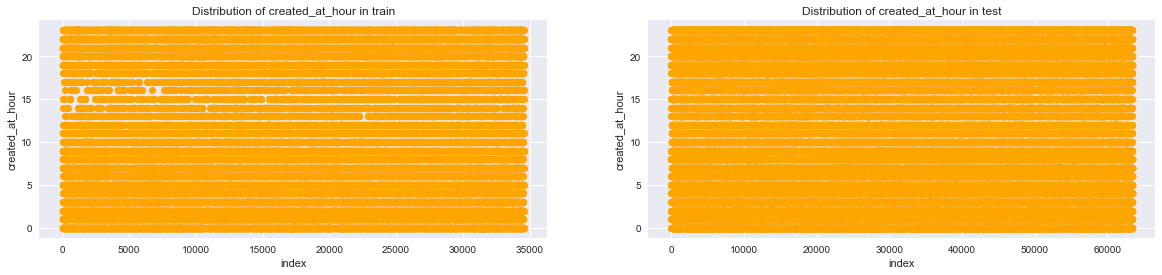

Distribution of launched_at_year


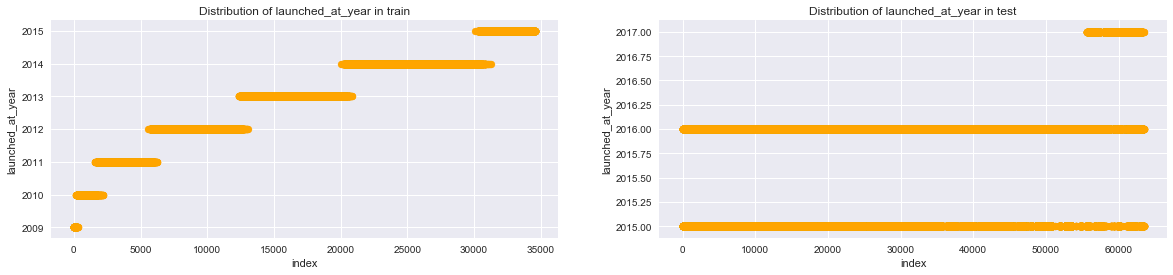

Distribution of launched_at_month


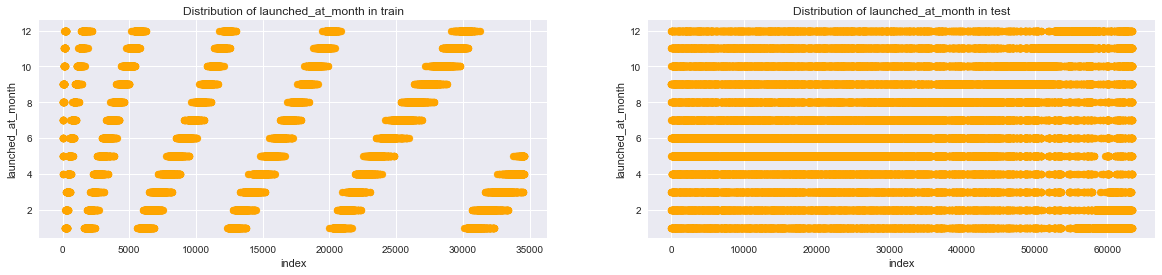

Distribution of launched_at_day


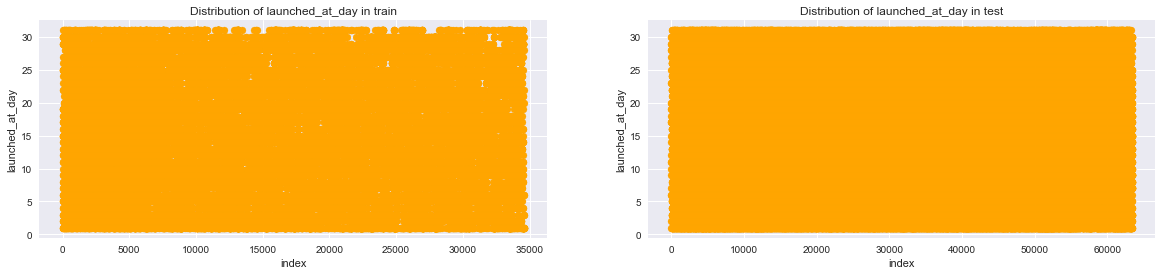

Distribution of launched_at_hour


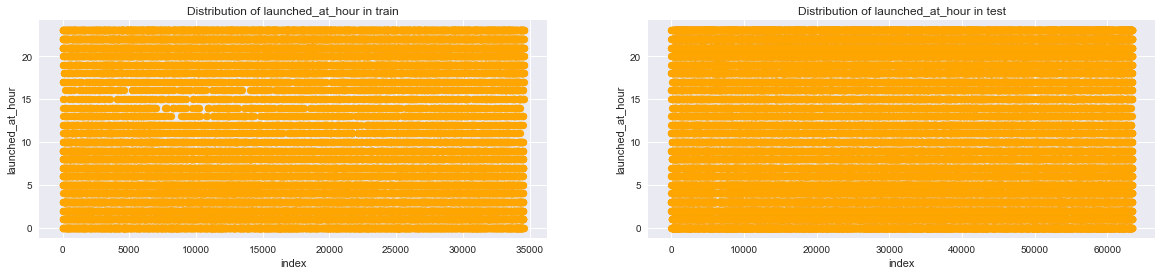

Distribution of goal_category


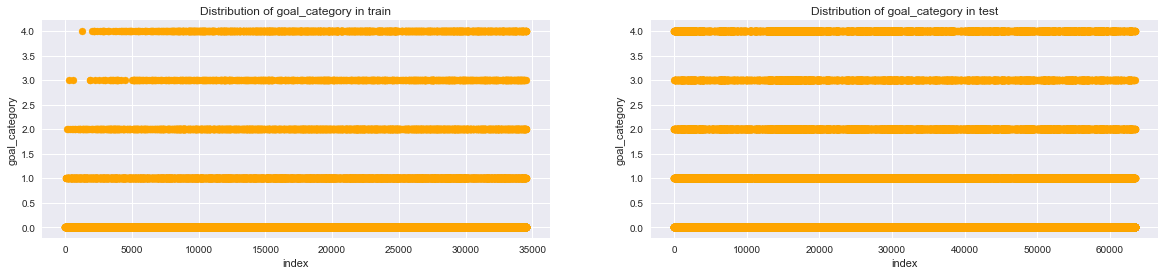

Distribution of len_name_category


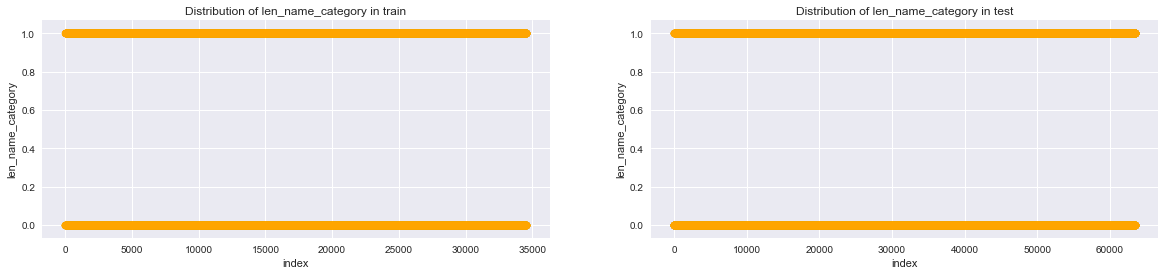

Distribution of len_keywords_category


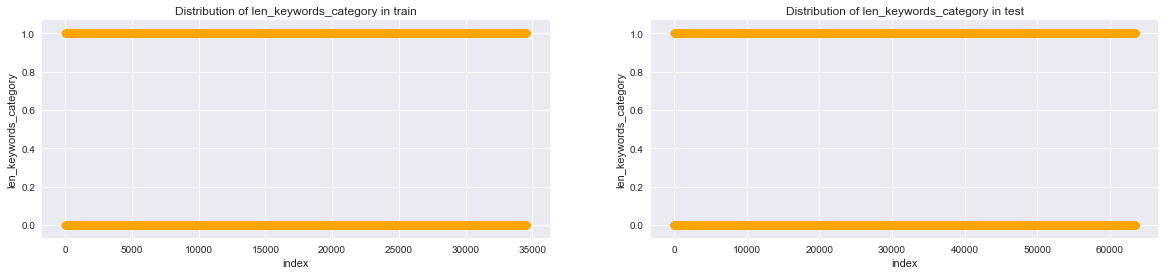

Distribution of count_name_category


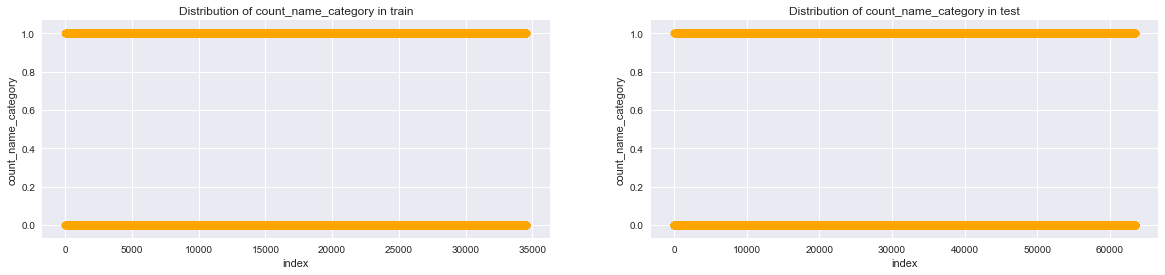

Distribution of count_keywords_category


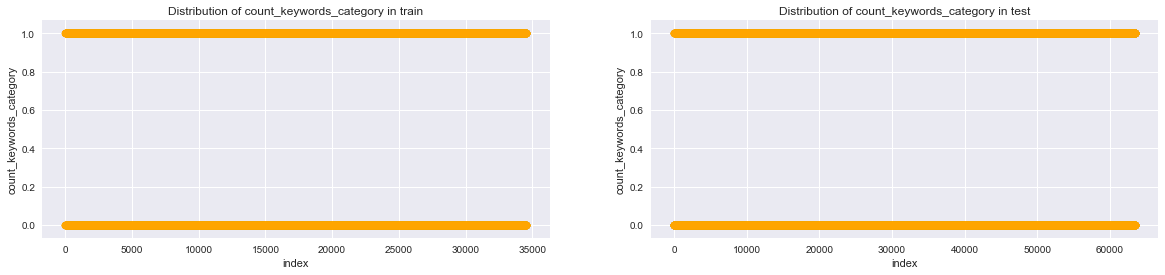

Distribution of created_at_deadline


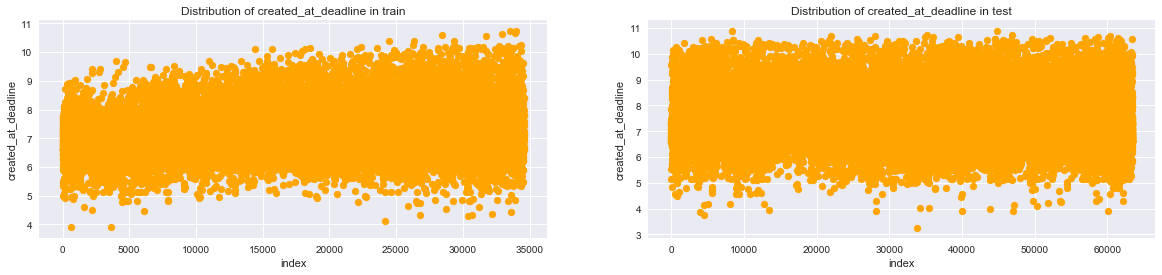

Distribution of created_at_launched_at


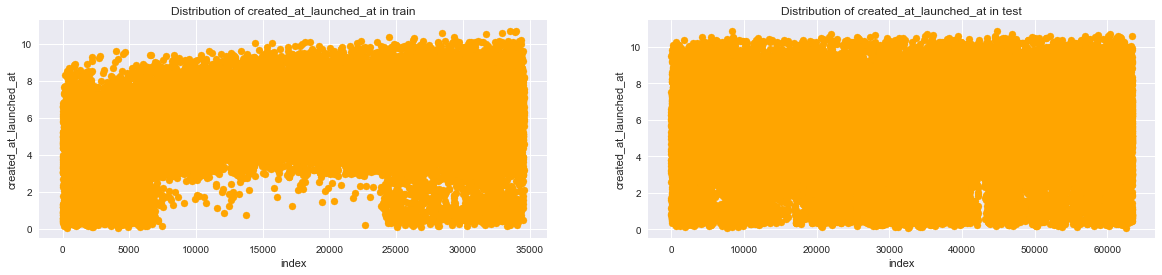

Distribution of launched_at_deadline


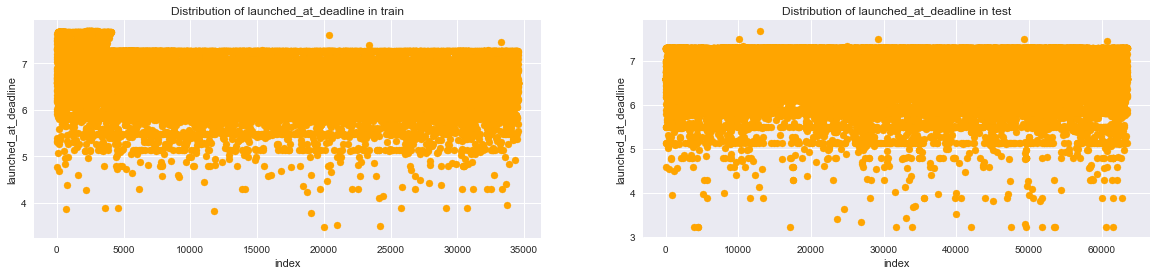

Distribution of deadline_month_category


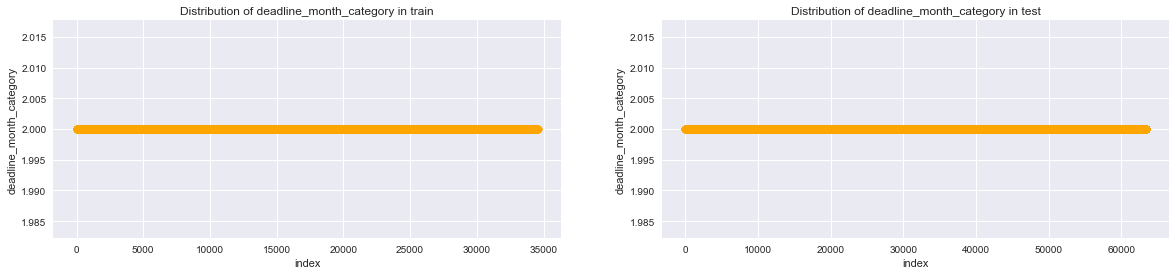

Distribution of state_changed_at_month_category


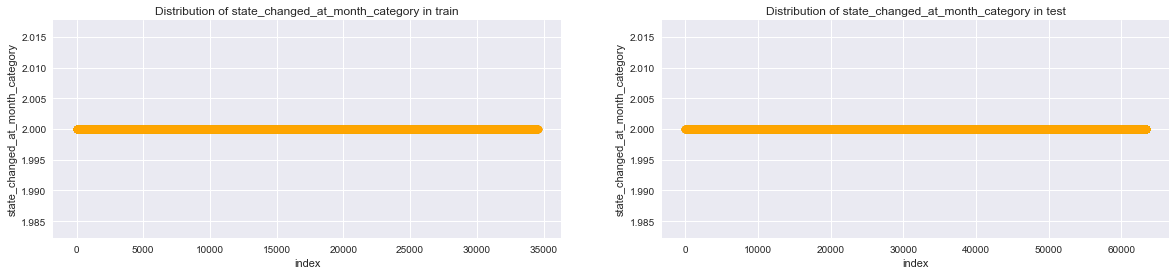

Distribution of launched_at_month_category


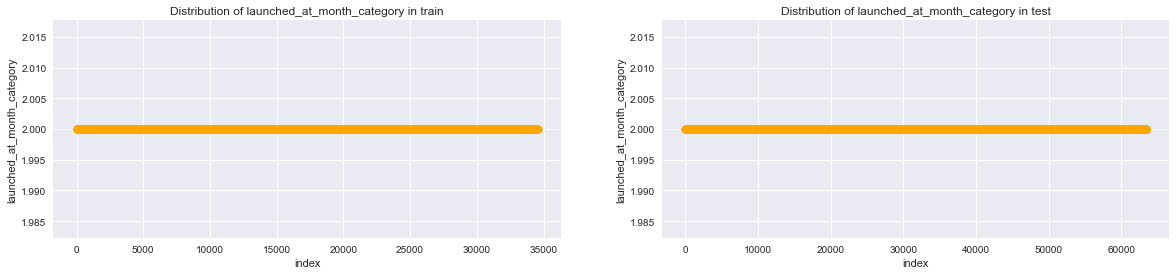

Distribution of created_at_month_category


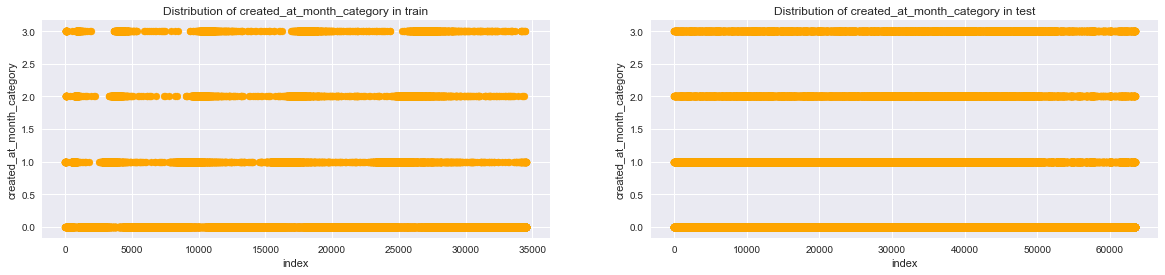

Distribution of deadline_state_changed_at_sign


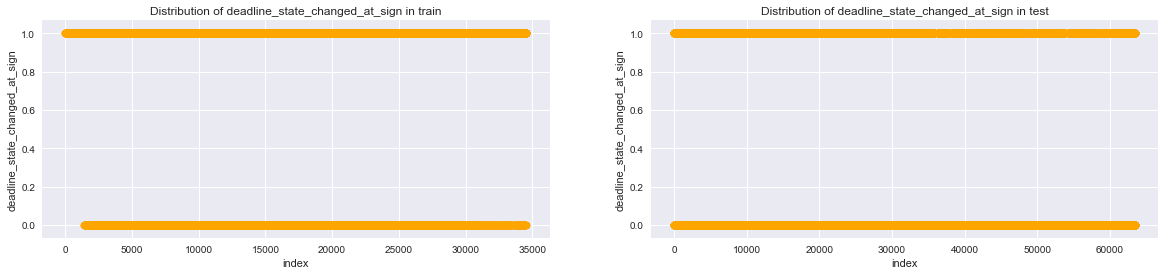

In [531]:
# We are going to select the features which are not text mining features and have a look at their distribution
normal_features = [i for i in features_to_use if 'variable' not in i]
train_text_final_status_1 = train_text[train_text['final_status'] == 1]

for col in normal_features:
    print ('Distribution of ' + str(col))
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,4))
    ax[0].scatter(range(train_text_final_status_1.shape[0]), train_text_final_status_1[col].values,color='orange')
    ax[0].set_title("Distribution of "+ str(col) + " in train")
    ax[0].set_xlabel("index")
    ax[0].set_ylabel(str(col))
    ax[1].scatter(range(test_text.shape[0]), test_text[col].values,color='orange')
    ax[1].set_title("Distribution of " + str(col) + " in test")
    ax[1].set_xlabel("index")
    ax[1].set_ylabel(str(col))
    plt.show()

Nothing much really could be gathered from the above plots

#### Experiment 2
##### We are going to undersample the majority class of the train dataset here to 50/50 ratio. Lets see what kind of distribution of the target variable in the test dataset this particular type of experiment generates

In [532]:
final_status_0_indices = np.array(train_text[train_text['final_status']==0].index)
final_status_1_indices = np.array(train_text[train_text['final_status']==1].index)

# out of the indices of the final_status column which is 0 we are going to select randomly x values 
# which is equal to the number of final_status values which is equal to 1
np.random.seed(1234)
random_final_status_0_indices = np.random.choice(final_status_0_indices, len(final_status_1_indices), replace=False)
random_final_status_0_indices = np.array(random_final_status_0_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([final_status_1_indices, random_final_status_0_indices])

# Under sampled train dataset
train_text_under_sample = train_text.iloc[under_sample_indices,:]

In [533]:
# how many #1s and #0s are there in final_status in new train
train_text_under_sample['final_status'].value_counts()

1    34561
0    34561
Name: final_status, dtype: int64

In [534]:
# Lets check the #1s after predicting with logistic regression on the new train
lr2 = LogisticRegression()
lr2_score = cross_val_score(lr2, train_text_under_sample[features_to_use], train_text_under_sample['final_status'], 
                            scoring = 'accuracy', cv = 5).mean()

print ("Accuracy with logistic regression on new train " + str(round(lr2_score * 100, 2)))

lr2.fit(train_text_under_sample[features_to_use], np.ravel(train_text_under_sample['final_status']))
test_X = test_text[features_to_use]
preds_lr2_new_prob = lr2.predict_proba(test_X)[:,1] # we will need this probability for ensembling purposes later on
preds_lr2_new = lr2.predict(test_X)
percentage_lr_new = round((np.bincount(preds_lr2_new)[1]/(np.bincount(preds_lr2_new)[0]
                                                    +np.bincount(preds_lr2_new)[1])) * 100, 2)
print ("#1s percentage in the prediction is " + str(percentage_lr_new))

submission = pd.DataFrame({"final_status":preds_lr2_new})
submission.insert(0, "project_id", test_ids)
submission.to_csv("lr2_0.5th_150tf.csv", index=False) #0.71322 leaderboard score

Accuracy with logistic regression on new train 61.63
#1s percentage in the prediction is 31.75


##### The local cv score for logistic regression is lower than the leaderboard score. I think the model lr2 is suffering from bias. The leaderboard score has incresed from earlier scores. Modeling on undersampled train dataset is the correct way to go
With #1s percentage as 31.75 and since the model is suffering from bias, the correct percentage of #1s in the test dataset will be around 25%.(This is just a hunch, I will not be able to back this up)

Lets run xgboost on it. We will also increase the depth of the model so that it does not suffer from bias

In [535]:
# customized xgboost function
def runXGB1(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=4000):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.07
    param['max_depth'] = 7
    param['silent'] = 0
    param['eval_metric'] = "error"
    param['min_child_weight'] = 6
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100,verbose_eval=100)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [536]:
train_X = np.array(train_text_under_sample[features_to_use])
train_y = np.array(train_text_under_sample['final_status'])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, xgbmodel1 = runXGB1(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.376133	test-error:0.38387
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.285043	test-error:0.328825
[200]	train-error:0.259381	test-error:0.323689
[300]	train-error:0.241026	test-error:0.3234
Stopping. Best iteration:
[250]	train-error:0.249887	test-error:0.322532

[0.67638336347197103]


In [537]:
test_X = np.array(test_text[features_to_use])
xgtest = xgb.DMatrix(test_X)
preds1 = xgbmodel1.predict(xgtest)
preds_binarize = binarize([preds1], 0.5)[0].astype(int)
submission = pd.DataFrame({"final_status":preds_binarize})
submission.insert(0, "project_id", test_ids)
submission.to_csv("xgb1_0.5th_150tf.csv", index=False) #0.72794 leaderboard score

Again, the local cv score is less than the leaderboard score. We are suffering from bias loss. The leaderboard score has increased again

In [538]:
percentage_xgb = round(submission['final_status'].value_counts()[1]/(submission['final_status'].value_counts()[1]+
                                                              submission['final_status'].value_counts()[0]) * 100, 2)

print ("#1s percentage in the prediction is " + str(percentage_xgb))

#1s percentage in the prediction is 24.22


The logistic regression and the xgboost is giving us a local cv accuracy score of 61% and 68% respectively. The leaderboard scores is higher than the local cv score

At this point I want to take a pause. Let us summarize a bit
1. Our experiment with backers_count feature did not prove to be successful
2. Our experiment with selecting samples from recent year also did not prove to be that successful
3. However undersampling the train dataset to get a ratio of 50/50 in the target variable of train dataset has been the best attempt so far in modeling related to this problem

On the undersampled train dataset, 
1. The model's name was xgbmodel1
2. The local cv score was 0.6763
3. The leaderboard score was 0.72794
4. The train dataset was train_text_under_sample

In [553]:
# We had earlier derived the importance values of the variables by using random forest and they have been stored in a dataframe
# 'importances' dataframe
importances

,feature,importance
31,created_at_launched_at,0.071
0,goal,0.070
30,created_at_deadline,0.063
32,launched_at_deadline,0.051
7,count_desc,0.050
6,count_name,0.047
19,created_at_day,0.045
20,created_at_hour,0.043
23,launched_at_day,0.043
4,len_desc,0.042


In [554]:
# lets remove the least important 4 variables whose importance values are 0
feats_to_remove = ['deadline_month_category', 'state_changed_at_month_category',
                  'launched_at_month_category','disable_communication']
for feats in feats_to_remove:
    features_to_use.remove(feats)

In [555]:
len(features_to_use)

334

In [557]:
train_X = np.array(train_text_under_sample[features_to_use])
train_y = np.array(train_text_under_sample['final_status'])

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, xgbmodel1 = runXGB1(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, binarize([preds], 0.5)[0]))
        print(cv_scores)
        break

[0]	train-error:0.377869	test-error:0.378517
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[100]	train-error:0.285603	test-error:0.325642
[200]	train-error:0.261099	test-error:0.322893
[300]	train-error:0.242653	test-error:0.320217
Stopping. Best iteration:
[245]	train-error:0.251713	test-error:0.319349

[0.67819168173598554]


Marginal improvement in the local cv score has been observed. It has increased from 0.6763 to 0.6781

In [558]:
# Lets make a prediction using the new sets of features of test data
test_X = np.array(test_text[features_to_use])
xgtest = xgb.DMatrix(test_X)
preds1 = xgbmodel1.predict(xgtest)
preds_binarize = binarize([preds1], 0.5)[0].astype(int)
submission = pd.DataFrame({"final_status":preds_binarize})
submission.insert(0, "project_id", test_ids)
submission.to_csv("xgb3_0.5th_150tf.csv", index=False) #0.72539 leaderboard score

percentage_xgb = round(submission['final_status'].value_counts()[1]/(submission['final_status'].value_counts()[1]+
                                                              submission['final_status'].value_counts()[0]) * 100, 2)

print ("#1s percentage in the prediction is " + str(percentage_xgb))

#1s percentage in the prediction is 23.13


In [617]:
# Lets use logistic regression on the new sets of features and see how it is doing
lr4 = LogisticRegression()
lr4_score = cross_val_score(lr4, train_text_under_sample[features_to_use], train_text_under_sample['final_status'], 
                            scoring = 'accuracy', cv = 5).mean()

print ("Accuracy with logistic regression " + str(round(lr4_score * 100, 2)))

Accuracy with logistic regression 61.82


The local cv score of the logistic regression is quite less. However its leaderboard score is not that bad.

In [620]:
# lets the store the prediction probability for the test dataset
lr4.fit(train_text_under_sample[features_to_use], np.ravel(train_text_under_sample['final_status']))
test_X = test_text[features_to_use]
preds_lr4_new_prob = lr4.predict_proba(test_X)[:,1] # the probability for ensemblin purposes later on

##### Lets stack the models on the undersampled train dataset and try to improve our score
We are going to use a stacked model of 3 xgboost model with different parameters based on our discretion and 1 logistic regression model

In [559]:
from sklearn.cross_validation import KFold # for partitioning the dataset

In [589]:
NFOLDS = 5 # the number of partitions
SEED = 0 # random value for reproducibility

In [580]:
train_X = np.array(train_text_under_sample[features_to_use]) # train
train_y = np.array(train_text_under_sample['final_status']) # target of train
test_X = np.array(test_text[features_to_use]) # test

In [607]:
kf = KFold(train_text_under_sample.shape[0], n_folds=NFOLDS, shuffle=True, random_state=SEED)

# this is the Sklearn wrapper class for logistic regression
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, train_X, train_y):
        self.clf.fit(train_X, train_y)

    def predict_proba(self, x):
        return self.clf.predict_proba(x)

# this is the xgboost wrapper class for the xgboost model
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 600)

    def train(self, train_X, train_y):
        dtrain = xgb.DMatrix(train_X, label=train_y)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict_proba(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))
    
# to get the out of fold prediction using the algorithms
def get_oof(clf):
    oof_train = np.zeros((train_text_under_sample.shape[0],))
    oof_test = np.zeros((test_text.shape[0],))
    oof_test_skf = np.empty((NFOLDS, test_text.shape[0]))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = train_X[train_index]
        y_tr = train_y[train_index]
        x_te = train_X[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(test_X)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# We are going to use 3 xgboost models and 1 logistic regression 
# parameters of learning models
lr_params = {'random_state':8 }

xgb1_params = {
    'seed': 0,
    'colsample_bytree': 0.6,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.05,
    'objective': 'multi:softprob',
    'max_depth': 10,
    'min_child_weight': 8,
    'eval_metric': 'error',
    'num_class': 2,
}

xgb2_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.06,
    'objective': 'multi:softprob',
    'max_depth': 7,
    'min_child_weight': 6,
    'eval_metric': 'error',
    'num_class': 2
}

xgb3_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.8,
    'learning_rate': 0.06,
    'objective': 'multi:softprob',
    'max_depth': 5,
    'min_child_weight': 2,
    'eval_metric': 'error',
    'num_class': 2
}

In [608]:
# initialize the models
xg1 = XgbWrapper(seed=SEED, params=xgb1_params) 
xg2 = XgbWrapper(seed=SEED, params=xgb2_params)
xg3 = XgbWrapper(seed=SEED, params=xgb3_params)
lr = SklearnWrapper(clf=LogisticRegression, params= lr_params)

In [609]:
# get the out of fold predictions using the xgboost and the logistic regression models
xg1_oof_train, xg1_oof_test = get_oof(xg1)
xg2_oof_train, xg2_oof_test = get_oof(xg2)
xg3_oof_train, xg3_oof_test = get_oof(xg3)
lr_oof_train, lr_oof_test = get_oof(lr)

In [610]:
# printing the local cv scores of the 4 models
print("XG1-CV: {}".format(accuracy_score(train_y, binarize([np.ravel(xg1_oof_train)], 0.5)[0])))
print("XG2-CV: {}".format(accuracy_score(train_y, binarize([np.ravel(xg2_oof_train)], 0.5)[0])))
print("XG3-CV: {}".format(accuracy_score(train_y, binarize([np.ravel(xg3_oof_train)], 0.5)[0])))
print("LR-CV: {}".format(accuracy_score(train_y, binarize([np.ravel(lr_oof_train)], 0.5)[0])))

XG1-CV: 0.6798125054251902
XG2-CV: 0.6814183617372183
XG3-CV: 0.6807384045600532
LR-CV: 0.6552038424814097


In [611]:
# concatenating the outputs of the above 4 models for feeding into the scond layer model which will also be xgboost
train_X_stack = np.concatenate((xg1_oof_train, xg2_oof_train, xg3_oof_train, lr_oof_train), axis=1)
test_X_stack = np.concatenate((xg1_oof_test, xg2_oof_test, xg3_oof_test, lr_oof_test), axis=1)

In [618]:
# making the prediction using a second layer model 
final_model = xgb.XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=1500, silent=True, 
                                objective='binary:logistic', gamma=0, min_child_weight=3, subsample=0.6, 
                                colsample_bytree=0.6, scale_pos_weight=1,seed =0)
final_model_score = cross_val_score(final_model, train_X_stack, train_y, scoring = 'accuracy', cv = 5).mean()

print ("The final cross validation score of the stacking model is " + str(final_model_score)) # local cv score for the stacked model

final_model.fit(train_X_stack, train_y)
final_preds_stack = final_model.predict_proba(test_X_stack)

final_preds_stack = final_preds_stack[:,1] # get the probability for ensembling

The final cross validation score of the stacking model is 0.67056749629


#### For final prediction, we are going to use an ensemble of models between the stacked models, the xgboost model (xgbmodel1) and the logistic regression (lr4).  
The probabilities predicted by the models are stored in :-
1. Stacked model - 'final_preds_stack'
2. xgbmodel1 - 'preds_binarize'
3. lr4 - 'preds_lr4_new_prob'

<b> Weighted Average Ensembling </b>  
The weights of the ensembles will be as Final model = 0.6*final_preds_stack + 0.25*preds_binarize + 0.15preds_lr4_new_prob

In [634]:
final_preds_prob = 0.6 * final_preds_stack + 0.25 * preds_binarize + 0.15 * preds_lr4_new_prob
final_preds = binarize([final_preds_prob], 0.5).astype(int)

In [645]:
# distribution of #1 in final prediction
print ("The percentage of #1s in the prediction is "+ 
       str(round(np.bincount(final_preds[0])[1]/(np.bincount(final_preds[0])[1]+np.bincount(final_preds[0])[0])* 100,2)))

The percentage of #1s in the prediction is 23.18


In [647]:
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.5th_150tf.csv", index=False) # 0.72595 leaderboard score

In [668]:
# Lets build a for loop to get the percentage of #1s in the prediction if we vary the threshold between 0.3 and 0.5 in steps of 0.01
for threshold in np.linspace(0.3, 0.5, 21):
    test_predictions = binarize([final_preds_prob], threshold)[0].astype(int)
    print ("threshold of probability is " + str(threshold))
    print (str(round((np.bincount(test_predictions)[1]/(np.bincount(test_predictions)[1]+ 
                                                       np.bincount(test_predictions)[0]))* 100,2)))
    print ("="*30)

threshold of probability is 0.3
40.78
threshold of probability is 0.31
38.98
threshold of probability is 0.32
37.15
threshold of probability is 0.33
35.48
threshold of probability is 0.34
33.9
threshold of probability is 0.35
32.29
threshold of probability is 0.36
30.62
threshold of probability is 0.37
29.02
threshold of probability is 0.38
27.47
threshold of probability is 0.39
26.23
threshold of probability is 0.4
25.25
threshold of probability is 0.41
24.68
threshold of probability is 0.42
24.25
threshold of probability is 0.43
23.91
threshold of probability is 0.44
23.66
threshold of probability is 0.45
23.52
threshold of probability is 0.46
23.41
threshold of probability is 0.47
23.35
threshold of probability is 0.48
23.28
threshold of probability is 0.49
23.22
threshold of probability is 0.5
23.18


In [669]:
# lets make a prediction setting the threshold as 0.45 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.45).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.45th_150tf.csv", index=False) # 0.72662. Increased

In [670]:
# lets make a prediction setting the threshold as 0.4 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.4).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.4th_150tf.csv", index=False) # 0.72952. Increased

In [672]:
# lets make a prediction setting the threshold as 0.3 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.3).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.3th_150tf.csv", index=False) # 0.72139. Decreased

In [673]:
# lets make a prediction setting the threshold as 0.38 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.38).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.38th_150tf.csv", index=False) # 0.73254. Increased

In [674]:
# lets make a prediction setting the threshold as 0.37 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.37).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.37th_150tf.csv", index=False) # 0.73276. Increased

In [675]:
# lets make a prediction setting the threshold as 0.36 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.36).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.36th_150tf.csv", index=False) # 0.73160. Decreased

In [676]:
# lets make a prediction setting the threshold as 0.365 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.365).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.365th_150tf.csv", index=False) # 0.73311. Increased

In [677]:
# Lets plot the distribution of #1 again for threshold between 0.36 and 0.37
for threshold in np.linspace(0.36, 0.37, 11):
    test_predictions = binarize([final_preds_prob], threshold)[0].astype(int)
    print ("threshold of probability is " + str(threshold))
    print (str(round((np.bincount(test_predictions)[1]/(np.bincount(test_predictions)[1]+ 
                                                       np.bincount(test_predictions)[0]))* 100,2)))
    print ("="*30)

threshold of probability is 0.36
30.62
threshold of probability is 0.361
30.48
threshold of probability is 0.362
30.34
threshold of probability is 0.363
30.16
threshold of probability is 0.364
29.96
threshold of probability is 0.365
29.8
threshold of probability is 0.366
29.65
threshold of probability is 0.367
29.47
threshold of probability is 0.368
29.34
threshold of probability is 0.369
29.16
threshold of probability is 0.37
29.02


In [678]:
# lets make a prediction setting the threshold as 0.367 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.367).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.367th_150tf.csv", index=False) # 0.73298. Increased

In [680]:
# lets make a prediction setting the threshold as 0.363 and see the leaderboard score
final_preds = binarize([final_preds_prob], 0.363).astype(int)
final_submission = pd.DataFrame({"final_status":final_preds[0]})
final_submission.insert(0, "project_id", test_ids)
final_submission.to_csv("Final_0.363th_150tf.csv", index=False) # 0.73213. Decreased

In [681]:
# Based on the leaderscore of threshold 0.365, we are going to use threshold as 0.365 and make the final submission
# the name of the submission file is Final_0.365th_150tf.csv
# Thus by modifying our threshold vaue from 0.5 to 0.365 we have been able to increase our score from 0.72595 to 0.73311